In [37]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import math
import os
import warnings
from collections import OrderedDict
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

try:
    from scipy import stats
except Exception:  # pragma: no cover - SciPy is optional
    stats = None
    warnings.warn(
        "SciPy is not available; paired t-test p-values will be reported as NaN.",
        RuntimeWarning,
    )

warnings.filterwarnings("ignore")

plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
})

sns.set_theme(style="whitegrid")

In [38]:
# Configuration
# ----------------------------------------------------------------------
#HERE: COMMENT OUT PATHS YOU DON'T WANT TO RUN. For example, run analysis only for experimental day types. 
# Will automatically separate halt and no halt
# Root directories containing cohort-level folders with aligned data.
DATA_DIRS: List[Path] = [
    # Path("/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/Visual_mismatch_day4/").expanduser(),
    # Path("/Volumes/RanczLab2/DATA_NEW/Cohort3_rotation/Visual_mismatch_day4/").expanduser(),
    Path("/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/Visual_mismatch_day3").expanduser(),
    Path("/Volumes/RanczLab2/DATA_NEW/Cohort3_rotation/Visual_mismatch_day3/").expanduser(),
]

OUTPUT_SUBDIR_NAME = "turning_analysis"

# Diagnostic settings
ENABLE_DECAY_DIAGNOSTICS = False  # Set True to run detailed diagnostics on decay fit failures
MAX_DIAGNOSTIC_EXAMPLES = 3       # Maximum number of failed fits to diagnose in detail

# Event file suffixes that encode turn direction in their names.
EVENT_SUFFIXES: List[str] = [
    "_Apply halt_2s_right_turns_baselined_data.csv",
    "_Apply halt_2s_left_turns_baselined_data.csv",
    "_No halt_right_turns_baselined_data.csv",
    "_No halt_left_turns_baselined_data.csv",
]

# Optional subset of mice to analyse (use [] to include every mouse found).
SELECTED_MICE: List[str] = []

# Data columns
TIME_COLUMN = "Time (s)"
VELOCITY_COLUMN = "Motor_Velocity"  # Motor turning velocity (deg/s)
RUNNING_COLUMN = "Velocity_0X_Baseline"      # Forward running velocity (m/s)

# Eye tracking columns (verify these match your CSV column names!)
SACCADE_COLUMN = "saccade_probability_eye1"  # Saccade probability - NO SCALING APPLIED, uses raw values from CSV
PUPIL_COLUMN = "Pupil.Diameter_eye1_Baseline"     # Pupil diameter (COMBINED across all turns)
EYE_POSITION_COLUMN = "Ellipse.Center.X_eye1_Baseline"  # Eye horizontal position (SEPARATED by turn direction)

# If saccade probability values are very small (< 0.01), check:
# 1. Is this the correct column name?
# 2. Are values per-frame probability (naturally small) vs aggregate probability?
# 3. Set SHOW_AVAILABLE_COLUMNS = True below to see all available columns

# ==================================================================================
# TIME WINDOW CONFIGURATION
# ==================================================================================
# All windows are (start, end) tuples in seconds, relative to turn onset (t=0)
# 
# USAGE GUIDE:
# - BASELINE_WINDOW: Pre-halt baseline for direction change detection & normalization
# - ANALYSIS_WINDOW_MEAN_PEAK: ⚙️ PRIMARY CONFIGURABLE WINDOW ⚙️
#   Controls the analysis window for:
#   • Post-halt mean velocity (turning & running)
#   • Peak velocity (turning & running)
#   • AUC calculation
#   Default: (0.0, 1.0) = analyze the first 1 second after halt onset
# - EXTENDED_RESPONSE_WINDOW: For mean absolute velocity (combines left/right turns)
# - FULL_RESPONSE_WINDOW: For exponential decay fitting (longer window needed)
# - TEMPORAL_DYNAMICS_WINDOWS: Fine-grained windows for temporal pattern analysis
# ==================================================================================

# Baseline (pre-turn) window
BASELINE_WINDOW = (-1.0, 0.0)  # Used for: direction detection, baseline normalization

# Post-turn response windows (used for primary metrics)
# ⚙️ USER CONFIGURABLE: Change this window to control mean and peak velocity analysis
ANALYSIS_WINDOW_MEAN_PEAK = (0.0, 2.0)  # Window for post-halt mean & peak velocity analysis

EARLY_RESPONSE_WINDOW = ANALYSIS_WINDOW_MEAN_PEAK  # Used for: peak velocity, AUC, post-turn mean
EXTENDED_RESPONSE_WINDOW = (0.0, 2.0)   # Used for: mean absolute velocity (combines left/right)
FULL_RESPONSE_WINDOW = (0.0, 3.0)       # Used for: exponential decay fitting

# Fine-grained temporal dynamics windows (used for alternative metrics)
TEMPORAL_EARLY_WINDOW = (0.0, 0.5)   # Immediate response phase
TEMPORAL_MID_WINDOW = (0.5, 1.0)     # Mid response phase
TEMPORAL_LATE_WINDOW = (1.0, 2.0)    # Sustained response phase
TEMPORAL_FULL_WINDOW = (0.0, 2.0)    # Full temporal analysis window

# Legacy compatibility (kept for function signatures, but values derived from above)
PRE_WINDOW = BASELINE_WINDOW           # Alias for backward compatibility
POST_WINDOW = EARLY_RESPONSE_WINDOW   # Alias for backward compatibility
PEAK_WINDOW = EARLY_RESPONSE_WINDOW   # Peak finding window (same as early response)
AUC_WINDOW = EARLY_RESPONSE_WINDOW    # Primary AUC window (same as early response)
DECAY_FIT_WINDOW = FULL_RESPONSE_WINDOW  # Decay fitting window

# Other thresholds
ZERO_THRESHOLD = 1e-2      # Threshold (deg/s) to treat near-zero values as zero
LATENCY_FRACTION = 0.5     # [DEPRECATED] Fraction of peak for latency calculation

# Mapping from inferred turn direction to expected velocity sign after time 0.
# Here we expect the actual turn to be opposite the label in the filename.
EXPECTED_DIRECTION_SIGN = {
    "right": -1,  # filenames tagged "right" should result in negative velocity
    "left": 1,    # filenames tagged "left" should result in positive velocity
}



In [39]:
# Utility functions
# ----------------------------------------------------------------------

def _iter_raw_mouse_dirs(data_dirs: Iterable[Path]) -> Iterable[Tuple[str, Path]]:
    """Yield (mouse_id, raw_dir) pairs for each mouse found in the data dirs."""
    for data_dir in data_dirs:
        base = Path(data_dir)
        if not base.exists():
            print(f"⚠️ Data directory not found: {base}")
            continue

        if base.is_dir() and base.name.endswith("_processedData"):
            raw_dir = base.with_name(base.name.replace("_processedData", ""))
            if raw_dir.exists():
                mouse_id = raw_dir.name.split("-")[0]
                yield mouse_id, raw_dir
            else:
                print(f"⚠️ Raw directory for processed data not found: {base}")
            continue

        if not base.is_dir():
            continue

        candidate_mouse_dirs = [
            subdir
            for subdir in base.iterdir()
            if subdir.is_dir() and "-" in subdir.name and not subdir.name.endswith("_processedData")
        ]
        if candidate_mouse_dirs:
            for subdir in candidate_mouse_dirs:
                mouse_id = subdir.name.split("-")[0]
                yield mouse_id, subdir
            continue

        mouse_id = base.name.split("-")[0]
        yield mouse_id, base


def find_turn_event_files(
    data_dirs: Iterable[Path],
    event_suffixes: Iterable[str],
    selected_mice: Optional[Iterable[str]] = None,
) -> List[Dict[str, object]]:
    """Locate aligned CSV files whose names encode turn direction."""
    selected = set(selected_mice or [])
    matches: List[Dict[str, object]] = []

    for mouse_id, raw_dir in _iter_raw_mouse_dirs(data_dirs):
        if selected and mouse_id not in selected:
            continue

        aligned_dir = raw_dir.parent / f"{raw_dir.name}_processedData" / "aligned_data"
        if not aligned_dir.exists():
            continue

        for suffix in event_suffixes:
            csv_path = aligned_dir / f"{mouse_id}{suffix}"
            if not csv_path.exists():
                continue
            direction = infer_direction_from_name(csv_path.name)
            group = infer_event_group(suffix)
            matches.append(
                {
                    "mouse": mouse_id,
                    "direction": direction,
                    "group": group,
                    "event_suffix": suffix,
                    "csv_path": csv_path,
                }
            )

    return matches


def infer_direction_from_name(filename: str) -> str:
    name = filename.lower()
    if "right" in name:
        return "right"
    if "left" in name:
        return "left"
    return "unknown"


def infer_event_group(name: str) -> str:
    lower = name.lower()
    if "no_halt" in lower or "no halt" in lower:
        return "No halt"
    if "apply" in lower:
        return "Apply halt"
    return "Unknown"


def load_time_series(
    csv_path: Path,
    time_column: str,
    value_column: str,
    value_alias: str = "velocity",
) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    if time_column not in df.columns:
        raise ValueError(f"Time column '{time_column}' not found in {csv_path}")
    if value_column not in df.columns:
        raise ValueError(f"Column '{value_column}' not found in {csv_path}")
    subset = df[[time_column, value_column]].copy()
    subset = subset.dropna()
    subset = subset.rename(columns={time_column: "time", value_column: value_alias})
    subset["time"] = pd.to_numeric(subset["time"], errors="coerce")
    subset[value_alias] = pd.to_numeric(subset[value_alias], errors="coerce")
    subset = subset.dropna()
    subset = subset.sort_values("time")
    return subset


def load_motor_velocity(
    csv_path: Path,
    time_column: str,
    velocity_column: str,
) -> pd.DataFrame:
    return load_time_series(csv_path, time_column, velocity_column, value_alias="velocity")


def compute_window_mean(df: pd.DataFrame, window: Tuple[float, float]) -> float:
    start, end = window
    mask = (df["time"] >= start) & (df["time"] < end if start < end else df["time"] <= end)
    if not mask.any():
        return float("nan")
    return float(df.loc[mask, "velocity"].mean())


def sign_with_threshold(value: float, threshold: float) -> int:
    if not math.isfinite(value) or abs(value) <= threshold:
        return 0
    return 1 if value > 0 else -1


def sem(values) -> float:
    arr = np.asarray(values, dtype=float)
    arr = arr[np.isfinite(arr)]
    n = arr.size
    if n <= 1:
        return 0.0 if n == 1 else float("nan")
    return float(arr.std(ddof=1) / np.sqrt(n))


def fit_exponential_decay(time_values: Iterable[float], amplitude_values: Iterable[float], verbose: bool = False) -> float:
    """
    Fit exponential decay: y = A * exp(-t/tau)
    
    NOTE: This often fails because motor velocity doesn't always show clean exponential decay.
    The velocity may:
    - Stay elevated (sustained turning)
    - Show complex multi-phase dynamics
    - Have noise that breaks the exponential assumption
    
    Consider using alternative metrics like AUC in different time windows instead.
    """
    time_arr = np.asarray(time_values, dtype=float)
    amp_arr = np.asarray(amplitude_values, dtype=float)
    mask = np.isfinite(time_arr) & np.isfinite(amp_arr)
    if mask.sum() < 3:
        if verbose:
            print(f"Decay fit failed: Only {mask.sum()} finite points")
        return float("nan")
    time_arr = time_arr[mask]
    amp_arr = amp_arr[mask]
    amp_arr = np.abs(amp_arr)
    positive_mask = amp_arr > 0
    if positive_mask.sum() < 3:
        if verbose:
            print(f"Decay fit failed: Only {positive_mask.sum()} positive amplitude points")
        return float("nan")
    time_arr = time_arr[positive_mask]
    amp_arr = amp_arr[positive_mask]
    time_arr = time_arr - time_arr.min()
    if time_arr.ptp() <= 0:
        if verbose:
            print("Decay fit failed: No time variation")
        return float("nan")
    log_amp = np.log(amp_arr)
    slope, intercept = np.polyfit(time_arr, log_amp, 1)
    if slope >= 0:
        if verbose:
            print(f"Decay fit failed: Non-decaying (slope={slope:.6f})")
            print(f"  → Signal is increasing or flat, not exponentially decaying")
            print(f"  → Consider using AUC or sustained response metrics instead")
        return float("nan")
    tau = -1.0 / slope
    return float(tau)


def assign_mouse_colors_consistent(mouse_ids: Iterable[str]) -> Dict[str, tuple]:
    normalized = [str(mouse) for mouse in mouse_ids]
    unique_mice = sorted(dict.fromkeys(normalized))
    if not unique_mice:
        return OrderedDict()
    palette = sns.color_palette("gnuplot2", len(unique_mice))
    return OrderedDict((mouse, palette[idx]) for idx, mouse in enumerate(unique_mice))


def compute_windowed_auc(
    df: pd.DataFrame,
    windows: List[Tuple[float, float]],
    time_col: str = "time",
    value_col: str = "velocity",
) -> Dict[str, float]:
    """
    Compute area under curve for multiple time windows.
    
    This is often more robust than decay fitting for characterizing response dynamics.
    Different windows capture different phases of the response:
    - Early (0-0.5s): Initial response magnitude
    - Mid (0.5-1s): Sustained response
    - Late (1-2s): Extended dynamics
    """
    auc_results = {}
    for start, end in windows:
        window_df = df[(df[time_col] >= start) & (df[time_col] <= end)]
        if not window_df.empty and len(window_df) > 1:
            auc = float(np.trapz(
                np.abs(window_df[value_col].to_numpy()),
                window_df[time_col].to_numpy()
            ))
            auc_results[f"auc_{start}_{end}s"] = auc
        else:
            auc_results[f"auc_{start}_{end}s"] = float("nan")
    return auc_results


def compute_sustained_response_ratio(
    df: pd.DataFrame,
    early_window: Tuple[float, float] = (0.0, 0.5),
    late_window: Tuple[float, float] = (1.0, 2.0),
    time_col: str = "time",
    value_col: str = "velocity",
) -> float:
    """
    Compute ratio of late to early response magnitude.
    
    Ratio < 1: Response decays
    Ratio ~ 1: Response is sustained
    Ratio > 1: Response increases over time
    
    This can distinguish between transient vs sustained turning responses.
    """
    early_auc = compute_window_mean(df.rename(columns={time_col: "time", value_col: "velocity"}), early_window)
    late_auc = compute_window_mean(df.rename(columns={time_col: "time", value_col: "velocity"}), late_window)
    
    if math.isfinite(early_auc) and math.isfinite(late_auc) and abs(early_auc) > 1e-6:
        return float(abs(late_auc) / abs(early_auc))
    return float("nan")


def compute_time_to_baseline(
    df: pd.DataFrame,
    baseline_window: Tuple[float, float] = (-1.0, 0.0),
    post_start: float = 0.0,
    n_std: float = 2.0,
    time_col: str = "time",
    value_col: str = "velocity",
) -> float:
    """
    Compute time for response to return to baseline level (mean + n_std).
    
    Returns NaN if response never returns to baseline in the available data.
    This is more interpretable than tau for non-exponential dynamics.
    """
    baseline_df = df[(df[time_col] >= baseline_window[0]) & (df[time_col] < baseline_window[1])]
    if baseline_df.empty:
        return float("nan")
    
    baseline_mean = float(baseline_df[value_col].abs().mean())
    baseline_std = float(baseline_df[value_col].abs().std())
    threshold = baseline_mean + n_std * baseline_std
    
    post_df = df[df[time_col] >= post_start].sort_values(time_col)
    if post_df.empty:
        return float("nan")
    
    post_abs = post_df[value_col].abs()
    below_threshold = post_abs < threshold
    
    if not below_threshold.any():
        return float("nan")
    
    # Find first sustained return (at least 3 consecutive points below threshold)
    below_indices = post_df.index[below_threshold].tolist()
    if len(below_indices) < 3:
        return float("nan")
    
    for i in range(len(below_indices) - 2):
        if (below_indices[i+1] == below_indices[i] + 1 and 
            below_indices[i+2] == below_indices[i] + 2):
            return float(post_df.loc[below_indices[i], time_col])
    
    return float("nan")


def diagnostic_exponential_fit(
    time_values: Iterable[float],
    amplitude_values: Iterable[float],
    title: str = "Decay Fit Diagnostic",
    show_plots: bool = True,
) -> Tuple[float, Dict[str, object]]:
    """
    Detailed diagnostic of exponential decay fitting.
    
    Returns:
        tau: The decay time constant (NaN if fit fails)
        diagnostics: Dictionary with diagnostic information
    """
    time_arr = np.asarray(time_values, dtype=float)
    amp_arr = np.asarray(amplitude_values, dtype=float)
    
    diagnostics = {
        "title": title,
        "n_points_initial": len(time_arr),
        "time_range": (float(time_arr.min()), float(time_arr.max())) if len(time_arr) > 0 else (np.nan, np.nan),
        "amp_range": (float(amp_arr.min()), float(amp_arr.max())) if len(amp_arr) > 0 else (np.nan, np.nan),
        "failure_reason": None,
    }
    
    print(f"\n{'='*60}")
    print(f"{title}")
    print(f"{'='*60}")
    print(f"Initial data points: {len(time_arr)}")
    if len(time_arr) > 0:
        print(f"Time range: {time_arr.min():.3f} to {time_arr.max():.3f}")
        print(f"Amplitude range: {amp_arr.min():.3f} to {amp_arr.max():.3f}")
    
    # Check 1: Finite values
    mask = np.isfinite(time_arr) & np.isfinite(amp_arr)
    if mask.sum() < 3:
        diagnostics["failure_reason"] = f"Only {mask.sum()} finite points (need ≥3)"
        print(f"❌ FAIL: {diagnostics['failure_reason']}")
        return float("nan"), diagnostics
    
    time_arr = time_arr[mask]
    amp_arr = amp_arr[mask]
    diagnostics["n_points_finite"] = int(mask.sum())
    print(f"After finite check: {len(time_arr)} points")
    
    # Check 2: Absolute values
    amp_arr = np.abs(amp_arr)
    positive_mask = amp_arr > 0
    if positive_mask.sum() < 3:
        diagnostics["failure_reason"] = f"Only {positive_mask.sum()} positive amplitude points"
        print(f"❌ FAIL: {diagnostics['failure_reason']}")
        return float("nan"), diagnostics
    
    time_arr = time_arr[positive_mask]
    amp_arr = amp_arr[positive_mask]
    diagnostics["n_points_positive"] = int(positive_mask.sum())
    print(f"After positive check: {len(time_arr)} points")
    
    # Check 3: Time normalization
    time_arr = time_arr - time_arr.min()
    if time_arr.ptp() <= 0:
        diagnostics["failure_reason"] = f"No time variation (ptp={time_arr.ptp()})"
        print(f"❌ FAIL: {diagnostics['failure_reason']}")
        return float("nan"), diagnostics
    
    diagnostics["time_ptp"] = float(time_arr.ptp())
    print(f"Time variation (ptp): {time_arr.ptp():.3f}")
    
    # Check 4: Log transform and linear fit
    log_amp = np.log(amp_arr)
    slope, intercept = np.polyfit(time_arr, log_amp, 1)
    diagnostics["slope"] = float(slope)
    diagnostics["intercept"] = float(intercept)
    print(f"Log-linear fit: slope={slope:.6f}, intercept={intercept:.3f}")
    
    if slope >= 0:
        diagnostics["failure_reason"] = f"Non-decaying (slope={slope:.6f})"
        diagnostics["amp_start"] = float(amp_arr[0])
        diagnostics["amp_end"] = float(amp_arr[-1])
        diagnostics["amp_mean"] = float(amp_arr.mean())
        diagnostics["trend"] = "increasing" if amp_arr[-1] > amp_arr[0] else "decreasing"
        
        print(f"❌ FAIL: Positive or zero slope ({slope:.6f}) - not decaying!")
        print(f"   This means the signal is INCREASING or flat, not decaying.")
        print(f"\n   Amplitude at start: {amp_arr[0]:.3f}")
        print(f"   Amplitude at end: {amp_arr[-1]:.3f}")
        print(f"   Mean amplitude: {amp_arr.mean():.3f}")
        print(f"   Amplitude trend: {diagnostics['trend']}")
        
        if show_plots:
            # Create diagnostic plot
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            
            # Plot 1: Actual data
            axes[0].plot(time_arr, amp_arr, 'o-', label='Data', color='#1f77b4')
            axes[0].set_xlabel('Time (s)')
            axes[0].set_ylabel('|Velocity| (deg/s)')
            axes[0].set_title('Absolute Velocity vs Time')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # Plot 2: Log scale
            axes[1].plot(time_arr, log_amp, 'o-', label='Log(amplitude)', color='#1f77b4')
            axes[1].plot(time_arr, slope * time_arr + intercept, 'r--', 
                        label=f'Fit: slope={slope:.4f}', linewidth=2)
            axes[1].set_xlabel('Time (s)')
            axes[1].set_ylabel('Log(|Velocity|)')
            axes[1].set_title('Log Scale (should be linear for exponential decay)')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            plt.suptitle(f"{title} - Decay Fit Failed", fontsize=12)
            plt.tight_layout()
            plt.show()
        
        return float("nan"), diagnostics
    
    tau = -1.0 / slope
    diagnostics["tau"] = float(tau)
    diagnostics["failure_reason"] = None
    print(f"✅ SUCCESS: τ = {tau:.3f} s")
    
    if show_plots:
        # Create diagnostic plot for successful fit
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # Plot 1: Actual data with exponential fit
        fitted_curve = np.exp(intercept) * np.exp(slope * time_arr)
        axes[0].plot(time_arr, amp_arr, 'o', label='Data', alpha=0.6, color='#1f77b4')
        axes[0].plot(time_arr, fitted_curve, 'r-', label=f'Fit: τ={tau:.3f}s', linewidth=2)
        axes[0].set_xlabel('Time (s)')
        axes[0].set_ylabel('|Velocity| (deg/s)')
        axes[0].set_title('Exponential Decay Fit')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Log scale
        axes[1].plot(time_arr, log_amp, 'o', label='Log(amplitude)', color='#1f77b4')
        axes[1].plot(time_arr, slope * time_arr + intercept, 'r--', 
                    label=f'Fit: slope={slope:.4f}', linewidth=2)
        axes[1].set_xlabel('Time (s)')
        axes[1].set_ylabel('Log(|Velocity|)')
        axes[1].set_title('Log Scale')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Plot 3: Residuals
        residuals = log_amp - (slope * time_arr + intercept)
        axes[2].plot(time_arr, residuals, 'o', color='#1f77b4')
        axes[2].axhline(0, color='r', linestyle='--', linewidth=2)
        axes[2].set_xlabel('Time (s)')
        axes[2].set_ylabel('Residuals')
        axes[2].set_title('Fit Residuals')
        axes[2].grid(True, alpha=0.3)
        
        plt.suptitle(f"{title} - Decay Fit Successful", fontsize=12)
        plt.tight_layout()
        plt.show()
    
    return float(tau), diagnostics


def _sanitize_label(value: str) -> str:
    cleaned = re.sub(r"[^\w\-]+", "_", value)
    cleaned = re.sub(r"_+", "_", cleaned)
    return cleaned.strip("_")


def build_output_folder_name(base_name: str, data_dirs: Iterable[Path]) -> str:
    labels: List[str] = []
    for directory in data_dirs:
        try:
            path = Path(directory).expanduser()
        except Exception:
            continue
        if not path.exists():
            continue
        cohort = path.parent.name if path.parent != path else ""
        day = path.name
        parts = [part for part in (cohort, day) if part]
        if not parts:
            continue
        label = _sanitize_label("_".join(parts))
        if not label:
            continue
        if label not in labels:
            labels.append(label)
    if not labels:
        return base_name
    suffix = "__".join(labels)
    return f"{base_name}__{suffix}"


def determine_output_directory(data_dirs: Iterable[Path], folder_name: str) -> Optional[Path]:
    existing_dirs = []
    for directory in data_dirs:
        candidate = Path(directory).expanduser()
        if candidate.exists():
            existing_dirs.append(candidate)
    if not existing_dirs:
        print("⚠️ No existing data directories found; results will not be saved.")
        return None

    folder_name = build_output_folder_name(folder_name, existing_dirs)
    try:
        common_path = Path(os.path.commonpath([str(path) for path in existing_dirs]))
    except ValueError:
        common_path = existing_dirs[0]

    candidate_bases: List[Path] = []
    candidate_bases.append(common_path)
    for path in existing_dirs:
        if path not in candidate_bases:
            candidate_bases.append(path)
        parent = path.parent
        if parent not in candidate_bases:
            candidate_bases.append(parent)
    cwd_base = Path.cwd()
    if cwd_base not in candidate_bases:
        candidate_bases.append(cwd_base)

    for base in candidate_bases:
        target_dir = Path(base) / folder_name
        try:
            target_dir.mkdir(parents=True, exist_ok=True)
            return target_dir
        except Exception as exc:  # noqa: BLE001
            print(f"⚠️ Could not create output directory {target_dir}: {exc}")

    print("⚠️ Exhausted all fallback locations; results will not be saved.")
    return None


def compute_paired_t_test(
    pivot_df: pd.DataFrame,
    group_a: str,
    group_b: str,
) -> Dict[str, float]:
    result = {
        "n_pairs": 0,
        "mean_difference": float("nan"),
        "t_statistic": float("nan"),
        "p_value": float("nan"),
    }
    if group_a not in pivot_df.columns or group_b not in pivot_df.columns:
        return result
    paired = pivot_df[[group_a, group_b]].dropna()
    n_pairs = int(len(paired))
    result["n_pairs"] = n_pairs
    if n_pairs == 0:
        return result

    diff = paired[group_b] - paired[group_a]
    mean_diff = float(diff.mean())
    result["mean_difference"] = mean_diff

    if n_pairs < 2:
        return result

    if stats is not None:
        t_stat, p_value = stats.ttest_rel(
            paired[group_b].to_numpy(dtype=float),
            paired[group_a].to_numpy(dtype=float),
            nan_policy="omit",
        )
        result["t_statistic"] = float(t_stat)
        result["p_value"] = float(p_value)
    else:
        std_diff = diff.std(ddof=1)
        if math.isfinite(std_diff) and std_diff > 0:
            t_statistic = mean_diff / (std_diff / math.sqrt(n_pairs))
            result["t_statistic"] = float(t_statistic)
    return result


OUTPUT_DIR = determine_output_directory(DATA_DIRS, OUTPUT_SUBDIR_NAME)
if OUTPUT_DIR is not None:
    print(f"Output directory: {OUTPUT_DIR}")


def analyse_turn_direction(
    df: pd.DataFrame,
    pre_window: Tuple[float, float],
    post_window: Tuple[float, float],
    zero_threshold: float,
) -> Dict[str, float]:
    pre_mean = compute_window_mean(df, pre_window)
    post_mean = compute_window_mean(df, post_window)
    pre_sign = sign_with_threshold(pre_mean, zero_threshold)
    post_sign = sign_with_threshold(post_mean, zero_threshold)
    direction_changed = (pre_sign != 0 and post_sign != 0 and pre_sign != post_sign)
    return {
        "pre_mean": pre_mean,
        "post_mean": post_mean,
        "pre_sign": pre_sign,
        "post_sign": post_sign,
        "direction_changed": direction_changed,
    }


def summarise_results(results: pd.DataFrame) -> pd.DataFrame:
    if results.empty:
        return results
    group_cols = ["group", "direction", "expected_sign"]
    grouped = (
        results.groupby(group_cols, dropna=False)
        .agg(
            n_files=("mouse", "count"),
            n_mice=("mouse", "nunique"),
            mean_post_velocity=("post_mean", "mean"),
            fraction_direction_change=("direction_changed", "mean"),
        )
        .reset_index()
    )
    grouped["fraction_direction_change"] = grouped["fraction_direction_change"].round(3)
    return grouped


def compute_turn_timing_metrics(
    df: pd.DataFrame,
    expected_sign: float,
    zero_threshold: float,
    peak_window: Tuple[float, float],
    auc_window: Tuple[float, float],
    pre_window: Tuple[float, float],
    latency_fraction: float,
    decay_fit_window: Tuple[float, float],
) -> Dict[str, float]:
    sign_used = expected_sign
    if not math.isfinite(sign_used) or sign_used == 0:
        post_mean = compute_window_mean(df, (0.0, 1.0))
        fallback_sign = sign_with_threshold(post_mean, zero_threshold)
        sign_used = fallback_sign if fallback_sign != 0 else 1

    start_peak, end_peak = peak_window
    peak_subset = df[(df["time"] >= start_peak) & (df["time"] <= end_peak)]
    timing_metrics = {
        "sign_used": float(sign_used),
        "time_to_peak": float("nan"),
        "peak_velocity_signed": float("nan"),
        "peak_velocity_magnitude": float("nan"),
        "peak_velocity_abs_1s": float("nan"),
        "latency_to_fraction_peak": float("nan"),
        "auc_abs": float("nan"),
        "decay_tau": float("nan"),
    }
    if peak_subset.empty:
        return timing_metrics

    abs_velocity = peak_subset["velocity"].abs()
    if abs_velocity.isna().all():
        return timing_metrics

    peak_idx = abs_velocity.idxmax()
    peak_value_abs = abs_velocity.loc[peak_idx]
    if not math.isfinite(peak_value_abs) or peak_value_abs <= 0:
        return timing_metrics

    peak_time = float(peak_subset.loc[peak_idx, "time"])
    raw_peak_value = float(peak_subset.loc[peak_idx, "velocity"])
    timing_metrics["time_to_peak"] = peak_time
    timing_metrics["peak_velocity_signed"] = raw_peak_value
    timing_metrics["peak_velocity_magnitude"] = float(peak_value_abs)
    timing_metrics["peak_velocity_abs_1s"] = float(peak_value_abs)

    baseline_mask = (df["time"] >= pre_window[0]) & (df["time"] <= pre_window[1])
    baseline_abs = df.loc[baseline_mask, "velocity"].abs().mean()
    baseline_abs = float(baseline_abs) if math.isfinite(baseline_abs) else 0.0

    if 0 < latency_fraction < 1 and peak_value_abs > baseline_abs:
        target_value = baseline_abs + (peak_value_abs - baseline_abs) * latency_fraction
        time_values = peak_subset["time"].to_numpy(dtype=float)
        abs_values = abs_velocity.to_numpy(dtype=float)
        above_threshold_idx = np.where(abs_values >= target_value)[0]
        if above_threshold_idx.size:
            idx = int(above_threshold_idx[0])
            if idx == 0:
                latency_time = float(time_values[0])
            else:
                prev_idx = idx - 1
                y0 = abs_values[prev_idx]
                y1 = abs_values[idx]
                t0 = time_values[prev_idx]
                t1 = time_values[idx]
                if not math.isfinite(y0):
                    y0 = 0.0
                if not math.isfinite(y1) or math.isclose(y1, y0):
                    latency_time = float(t1)
                else:
                    fraction = (target_value - y0) / (y1 - y0)
                    fraction = min(max(fraction, 0.0), 1.0)
                    latency_time = float(t0 + fraction * (t1 - t0))
            timing_metrics["latency_to_fraction_peak"] = latency_time

    start_auc, end_auc = auc_window
    auc_subset = df[(df["time"] >= start_auc) & (df["time"] <= end_auc)]
    if not auc_subset.empty:
        auc_abs = auc_subset["velocity"].abs()
        auc_value = float(np.trapz(auc_abs.to_numpy(), auc_subset["time"].to_numpy()))
        timing_metrics["auc_abs"] = auc_value

    start_decay, end_decay = decay_fit_window
    if math.isfinite(peak_time):
        start_decay = max(start_decay, peak_time)
    decay_mask = (df["time"] >= start_decay) & (df["time"] <= end_decay)
    decay_subset = df.loc[decay_mask].copy()
    if not decay_subset.empty:
        decay_subset["abs_velocity"] = decay_subset["velocity"].abs()
        per_time = (
            decay_subset.groupby("time", dropna=False)["abs_velocity"]
            .mean()
            .reset_index()
            .sort_values("time")
        )
        tau = fit_exponential_decay(per_time["time"], per_time["abs_velocity"])
        if math.isfinite(tau):
            timing_metrics["decay_tau"] = float(tau)

    return timing_metrics


def plot_motor_velocity(df: pd.DataFrame, title: str, pre_window, post_window) -> None:
    fig, ax = plt.subplots(figsize=(6, 3.5))
    ax.plot(df["time"], df["velocity"], color="#1f77b4", linewidth=0.9)
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.axvspan(pre_window[0], pre_window[1], color="#2ca02c", alpha=0.15, label="Pre window")
    ax.axvspan(post_window[0], post_window[1], color="#d62728", alpha=0.15, label="Post window")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Motor velocity (deg/s)")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()



Output directory: /Volumes/RanczLab2/DATA_NEW/turning_analysis__Cohort1_rotation_Visual_mismatch_day3__Cohort3_rotation_Visual_mismatch_day3


In [40]:
# Load data and compute direction metrics
# ----------------------------------------------------------------------

turn_event_files = find_turn_event_files(DATA_DIRS, EVENT_SUFFIXES, SELECTED_MICE)
print(f"Found {len(turn_event_files)} turn-specific files")

records: List[Dict[str, object]] = []
trace_records: List[pd.DataFrame] = []
errors: List[str] = []

for entry in turn_event_files:
    csv_path = entry["csv_path"]
    try:
        df = load_motor_velocity(csv_path, TIME_COLUMN, VELOCITY_COLUMN)
    except Exception as exc:  # noqa: BLE001
        errors.append(f"{csv_path}: {exc}")
        continue

    metrics = analyse_turn_direction(df, PRE_WINDOW, POST_WINDOW, ZERO_THRESHOLD)
    expected_sign = EXPECTED_DIRECTION_SIGN.get(entry["direction"], np.nan)
    timing_metrics = compute_turn_timing_metrics(
        df,
        expected_sign,
        ZERO_THRESHOLD,
        PEAK_WINDOW,
        AUC_WINDOW,
        PRE_WINDOW,
        LATENCY_FRACTION,
        DECAY_FIT_WINDOW,
    )

    enriched_trace = df.copy()
    enriched_trace["group"] = entry["group"]
    enriched_trace["mouse"] = entry["mouse"]
    enriched_trace["direction"] = entry["direction"]
    enriched_trace["csv_path"] = str(csv_path)
    enriched_trace["sign_used"] = timing_metrics.get("sign_used", expected_sign)
    trace_records.append(enriched_trace)

    records.append(
        {
            **entry,
            **metrics,
            **timing_metrics,
            "expected_sign": expected_sign,
            "csv_path": str(csv_path),
        }
    )

results_df = pd.DataFrame(records)
trace_samples_df = pd.concat(trace_records, ignore_index=True) if trace_records else pd.DataFrame()

results_df

Found 30 turn-specific files


,mouse,direction,group,event_suffix,csv_path,pre_mean,post_mean,pre_sign,post_sign,direction_changed,sign_used,time_to_peak,peak_velocity_signed,peak_velocity_magnitude,peak_velocity_abs_1s,latency_to_fraction_peak,auc_abs,decay_tau,expected_sign
0,B6J2718,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,13.530291,9.357254,1,1,False,-1.0,0.339,26.0752,26.0752,26.0752,0.000000,23.761178,NaN,-1
1,B6J2718,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,-9.777662,-0.556130,-1,-1,False,1.0,0.547,23.4433,23.4433,23.4433,0.000000,17.004223,NaN,1
2,B6J2718,right,No halt,_No halt_right_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,12.181731,10.575994,1,1,False,-1.0,0.331,26.8365,26.8365,26.8365,0.000000,25.612171,3.977084,-1
3,B6J2718,left,No halt,_No halt_left_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,-11.300739,-3.530068,-1,-1,False,1.0,0.000,-24.8782,24.8782,24.8782,0.000000,15.839034,4.935154,1
4,B6J2719,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,12.572104,6.832870,1,1,False,-1.0,0.668,24.8638,24.8638,24.8638,0.000000,21.775076,3.196918,-1
5,B6J2719,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,-7.354136,-10.182178,-1,-1,False,1.0,1.394,-20.1912,20.1912,20.1912,0.000000,20.370257,NaN,1
6,B6J2719,right,No halt,_No halt_right_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,12.025561,8.552780,1,1,False,-1.0,0.469,29.9722,29.9722,29.9722,0.000000,21.498520,3.410496,-1
7,B6J2719,left,No halt,_No halt_left_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,-8.797664,-6.005923,-1,-1,False,1.0,0.098,-23.8226,23.8226,23.8226,0.000000,22.226748,3.495669,1
8,B6J2721,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,10.480691,8.556543,1,1,False,-1.0,0.274,25.6062,25.6062,25.6062,0.000000,20.887331,3.710946,-1
9,B6J2721,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,-16.216896,-5.921175,-1,-1,False,1.0,0.785,26.9132,26.9132,26.9132,0.000000,24.916380,9.024227,1


In [41]:
# Inspect any files that could not be processed
errors

[]

### Decay fit diagnostics (optional)
If enabled, diagnose why exponential decay fitting fails for specific examples

In [42]:
# Run detailed diagnostics on failed decay fits
# ----------------------------------------------------------------------

if ENABLE_DECAY_DIAGNOSTICS and not results_df.empty:
    print("\n" + "="*60)
    print("DECAY FIT DIAGNOSTICS")
    print("="*60)
    
    # Find files where decay fit failed (tau is NaN)
    failed_fits = results_df[results_df["decay_tau"].isna()].copy()
    
    if failed_fits.empty:
        print("✅ All decay fits succeeded (no NaN values)")
    else:
        n_failed = len(failed_fits)
        print(f"⚠️ Found {n_failed} failed decay fits out of {len(results_df)} total")
        print(f"   ({100 * n_failed / len(results_df):.1f}% failure rate)\n")
        
        # Analyze distribution of failures
        print("Failure distribution:")
        for group_name, group_df in failed_fits.groupby("group", dropna=False):
            n_group = len(group_df)
            n_group_total = len(results_df[results_df["group"] == group_name])
            print(f"  {group_name}: {n_group}/{n_group_total} failed ({100*n_group/n_group_total:.1f}%)")
        
        # Run detailed diagnostics on a few examples
        n_to_diagnose = min(MAX_DIAGNOSTIC_EXAMPLES, len(failed_fits))
        print(f"\nRunning detailed diagnostics on {n_to_diagnose} examples...")
        
        diagnostic_results = []
        
        for idx, row in failed_fits.head(n_to_diagnose).iterrows():
            csv_path = Path(row["csv_path"])
            try:
                df = load_motor_velocity(csv_path, TIME_COLUMN, VELOCITY_COLUMN)
            except Exception as exc:
                print(f"⚠️ Could not load {csv_path}: {exc}")
                continue
            
            # Extract decay window data
            decay_mask = (df["time"] >= DECAY_FIT_WINDOW[0]) & (df["time"] <= DECAY_FIT_WINDOW[1])
            decay_data = df.loc[decay_mask].copy()
            
            if decay_data.empty:
                print(f"⚠️ No data in decay window for {row['mouse']} - {row['group']}")
                continue
            
            # Group by time and average (same as original analysis)
            decay_data["abs_velocity"] = decay_data["velocity"].abs()
            per_time = (
                decay_data.groupby("time", dropna=False)["abs_velocity"]
                .mean()
                .reset_index()
                .sort_values("time")
            )
            
            # Run diagnostic
            title = f"{row['mouse']} | {row['group']} | {row['direction']} turn"
            tau, diag_info = diagnostic_exponential_fit(
                per_time["time"].values,
                per_time["abs_velocity"].values,
                title=title,
                show_plots=True,
            )
            
            diagnostic_results.append({
                "mouse": row["mouse"],
                "group": row["group"],
                "direction": row["direction"],
                "csv_path": str(csv_path),
                **diag_info,
            })
        
        # Save diagnostic results
        if diagnostic_results:
            diagnostic_df = pd.DataFrame(diagnostic_results)
            if OUTPUT_DIR is not None:
                diagnostic_df.to_csv(OUTPUT_DIR / "decay_fit_diagnostics.csv", index=False)
                print(f"\n✅ Saved diagnostic results to: {OUTPUT_DIR / 'decay_fit_diagnostics.csv'}")
            
            # Summary of failure reasons
            print("\n" + "-"*60)
            print("Summary of failure reasons:")
            if "failure_reason" in diagnostic_df.columns:
                for reason, count_df in diagnostic_df.groupby("failure_reason"):
                    if pd.notna(reason):
                        print(f"  {reason}: {len(count_df)} cases")
elif ENABLE_DECAY_DIAGNOSTICS:
    print("⚠️ Decay diagnostics enabled but no results available to diagnose")

### Running velocity summary


In [43]:
# Running velocity (Velocity_0X_Baseline) analysis
# ----------------------------------------------------------------------

running_records: List[Dict[str, object]] = []
running_trace_records: List[pd.DataFrame] = []
running_errors: List[str] = []
running_peak_diagnostics: List[Dict[str, object]] = []

if not results_df.empty:
    for _, row in results_df.iterrows():
        csv_path = Path(row["csv_path"])
        try:
            running_df = load_time_series(csv_path, TIME_COLUMN, RUNNING_COLUMN, value_alias="velocity")
        except Exception as exc:  # noqa: BLE001
            running_errors.append(f"{csv_path}: {exc}")
            continue

        peak_window_mask = (running_df["time"] >= 0.0) & (running_df["time"] <= 1.0)
        if peak_window_mask.any():
            raw_peak_abs_mps = float(running_df.loc[peak_window_mask, "velocity"].abs().max())
        else:
            raw_peak_abs_mps = float("nan")

        running_df["velocity"] = running_df["velocity"] * 100.0

        running_metrics = analyse_turn_direction(running_df, PRE_WINDOW, POST_WINDOW, ZERO_THRESHOLD)
        expected_sign = EXPECTED_DIRECTION_SIGN.get(row["direction"], np.nan)

        running_trace = running_df.copy()
        running_trace["group"] = row["group"]
        running_trace["mouse"] = row["mouse"]
        running_trace["turn_label"] = row["direction"]
        running_trace["csv_path"] = row["csv_path"]
        running_trace_records.append(running_trace)

        running_records.append(
            {
                "mouse": row["mouse"],
                "turn_label": row["direction"],
                "group": row["group"],
                "event_suffix": row["event_suffix"],
                "csv_path": row["csv_path"],
                **running_metrics,
                "expected_sign": expected_sign,
            }
        )

        running_peak_diagnostics.append(
            {
                "mouse": row["mouse"],
                "group": row["group"],
                "turn_label": row["direction"],
                "csv_path": row["csv_path"],
                "peak_abs_velocity_mps": raw_peak_abs_mps,
                "peak_abs_velocity_cmps": raw_peak_abs_mps * 100.0 if math.isfinite(raw_peak_abs_mps) else float("nan"),
            }
        )

running_results_df = pd.DataFrame(running_records)
if not running_results_df.empty:
    running_results_df["direction"] = "All turns"
running_trace_samples_df = pd.concat(running_trace_records, ignore_index=True) if running_trace_records else pd.DataFrame()
if not running_trace_samples_df.empty:
    running_trace_samples_df["direction"] = "All turns"

running_peak_diag_df = pd.DataFrame(running_peak_diagnostics)

# Save running results
if OUTPUT_DIR is not None and not running_results_df.empty:
    running_results_df.to_csv(OUTPUT_DIR / "running_velocity_per_file.csv", index=False)
    print(f"✅ Saved: running_velocity_per_file.csv")

running_results_df

✅ Saved: running_velocity_per_file.csv


,mouse,turn_label,group,event_suffix,csv_path,pre_mean,post_mean,pre_sign,post_sign,direction_changed,expected_sign,direction
0,B6J2718,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,3.466594,5.700237,1,1,False,-1,All turns
1,B6J2718,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,5.281786,8.486131,1,1,False,1,All turns
2,B6J2718,right,No halt,_No halt_right_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,3.608650,5.304619,1,1,False,-1,All turns
3,B6J2718,left,No halt,_No halt_left_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,2.315270,3.459228,1,1,False,1,All turns
4,B6J2719,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,6.138255,9.395784,1,1,False,-1,All turns
5,B6J2719,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,-8.656533,-4.483400,-1,-1,False,1,All turns
6,B6J2719,right,No halt,_No halt_right_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,3.033530,5.104441,1,1,False,-1,All turns
7,B6J2719,left,No halt,_No halt_left_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,-0.293136,3.139801,-1,1,True,1,All turns
8,B6J2721,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,7.217740,9.445661,1,1,False,-1,All turns
9,B6J2721,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,2.652039,10.547218,1,1,False,1,All turns


In [44]:
if running_peak_diag_df.empty:
    print("⚠️ No running peak diagnostics available")
else:
    display(Markdown("#### Running peak velocity diagnostics (per file)"))
    display(
        running_peak_diag_df.sort_values("peak_abs_velocity_cmps", ascending=False)
        .reset_index(drop=True)
    )
    if OUTPUT_DIR is not None:
        running_peak_diag_df.to_csv(OUTPUT_DIR / "running_peak_velocity_diagnostic.csv", index=False)
        print(f"✅ Saved: running_peak_velocity_diagnostic.csv")

#### Running peak velocity diagnostics (per file)

,mouse,group,turn_label,csv_path,peak_abs_velocity_mps,peak_abs_velocity_cmps
0,B6J2721,Apply halt,right,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.275377,27.537726
1,B6J2718,No halt,right,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.258481,25.848051
2,B6J2719,No halt,right,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.256850,25.685017
3,B6J2718,Apply halt,left,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.244479,24.447866
4,B6J2721,No halt,left,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.243819,24.381889
5,B6J2719,No halt,left,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.240932,24.093203
6,B6J2721,No halt,right,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.232043,23.204348
7,B6J2722,No halt,left,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.224356,22.435577
8,B6J2718,Apply halt,right,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.221326,22.132614
9,B6J2718,No halt,left,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.215800,21.579960


✅ Saved: running_peak_velocity_diagnostic.csv


In [45]:
running_summary_df = summarise_results(running_results_df)
if running_summary_df.empty:
    print("⚠️ No running velocity statistics available")
else:
    for group_name, subdf in running_summary_df.groupby("group", dropna=False):
        title = group_name if isinstance(group_name, str) else "Unknown"
        display(Markdown(f"#### {title}"))
        display(subdf.drop(columns=["group"], errors="ignore").reset_index(drop=True))

#### Apply halt

,direction,expected_sign,n_files,n_mice,mean_post_velocity,fraction_direction_change
0,All turns,-1,8,8,3.413085,0.250
1,All turns,1,7,7,4.592010,0.143


#### No halt

,direction,expected_sign,n_files,n_mice,mean_post_velocity,fraction_direction_change
0,All turns,-1,8,8,1.710424,0.250
1,All turns,1,7,7,2.506848,0.143


In [46]:
if running_results_df.empty:
    running_mouse_means = pd.DataFrame()
else:
    running_mouse_means = (
        running_results_df.groupby(["group", "mouse"], dropna=False)
        .agg(
            post_mean=("post_mean", "mean"),
            pre_mean=("pre_mean", "mean"),
            n_files=("csv_path", "count"),
        )
        .reset_index()
    )
    running_mouse_means["expected_sign"] = np.nan
    running_mouse_means["post_sign"] = running_mouse_means["post_mean"].apply(lambda v: sign_with_threshold(v, ZERO_THRESHOLD))
    running_mouse_means["direction"] = "All turns"

running_mouse_means

# Save running per-mouse metrics
if OUTPUT_DIR is not None and not running_mouse_means.empty:
    running_mouse_means.to_csv(OUTPUT_DIR / "running_velocity_per_mouse.csv", index=False)
    print(f"✅ Saved: running_velocity_per_mouse.csv")

if running_trace_samples_df.empty:
    running_peak_abs_df = pd.DataFrame()
else:
    running_peak_mask = (running_trace_samples_df["time"] >= 0.0) & (running_trace_samples_df["time"] <= 1.0)
    running_peak_subset = running_trace_samples_df.loc[running_peak_mask].copy()
    if running_peak_subset.empty:
        running_peak_abs_df = pd.DataFrame()
    else:
        running_peak_subset["abs_velocity"] = running_peak_subset["velocity"].abs()
        running_per_record_peak = (
            running_peak_subset.groupby(["mouse", "group", "csv_path"], dropna=False)["abs_velocity"]
            .max()
            .reset_index(name="peak_velocity_abs_1s")
        )
        running_peak_abs_df = (
            running_per_record_peak.groupby(["mouse", "group"], dropna=False)["peak_velocity_abs_1s"]
            .mean()
            .reset_index()
        )

if running_mouse_means.empty and running_peak_abs_df.empty:
    running_metrics_combined = pd.DataFrame()
else:
    if running_mouse_means.empty:
        running_metrics_combined = running_peak_abs_df.copy()
    else:
        running_metrics_combined = running_mouse_means[["group", "mouse", "post_mean"]].copy()
        if "direction" in running_mouse_means.columns and "direction" not in running_metrics_combined.columns:
            running_metrics_combined["direction"] = running_mouse_means["direction"]
        if "n_files" in running_mouse_means.columns and "n_files" not in running_metrics_combined.columns:
            running_metrics_combined["n_files"] = running_mouse_means["n_files"]
        if "pre_mean" in running_mouse_means.columns and "pre_mean" not in running_metrics_combined.columns:
            running_metrics_combined["pre_mean"] = running_mouse_means["pre_mean"]
        if "expected_sign" in running_mouse_means.columns and "expected_sign" not in running_metrics_combined.columns:
            running_metrics_combined["expected_sign"] = running_mouse_means["expected_sign"]
        if "post_sign" in running_mouse_means.columns and "post_sign" not in running_metrics_combined.columns:
            running_metrics_combined["post_sign"] = running_mouse_means["post_sign"]
        if running_peak_abs_df.empty:
            pass
        else:
            running_metrics_combined = pd.merge(
                running_metrics_combined,
                running_peak_abs_df,
                on=["mouse", "group"],
                how="outer",
            )

✅ Saved: running_velocity_per_mouse.csv


In [47]:
if running_trace_samples_df.empty:
    running_per_mouse_traces = pd.DataFrame()
    running_avg_traces = pd.DataFrame()
    print("⚠️ No running traces available. Ensure the running velocity analysis cell completed successfully.")
else:
    running_per_mouse_traces = (
        running_trace_samples_df
        .groupby(["group", "mouse", "time"], dropna=False)["velocity"]
        .mean()
        .reset_index()
    )
    running_per_mouse_traces["direction"] = "All turns"
    running_avg_traces = (
        running_per_mouse_traces
        .groupby(["group", "direction", "time"], dropna=False)
        .agg(
            mean_velocity=("velocity", "mean"),
            sem_velocity=("velocity", lambda x: sem(x) if len(x.dropna()) > 1 else 0.0),
            n_mice=("mouse", "nunique"),
        )
        .reset_index()
    )

    n_traces = running_trace_samples_df["csv_path"].nunique()
    n_mice_traces = running_trace_samples_df["mouse"].nunique()
    print(f"✅ Running traces aggregated: {n_traces} files across {n_mice_traces} mice.")
    
    # Save running average traces
    if OUTPUT_DIR is not None:
        running_avg_traces.to_csv(OUTPUT_DIR / "running_velocity_avg_traces.csv", index=False)
        print(f"✅ Saved: running_velocity_avg_traces.csv")

running_avg_traces

✅ Running traces aggregated: 30 files across 8 mice.
✅ Saved: running_velocity_avg_traces.csv


,group,direction,time,mean_velocity,sem_velocity,n_mice
0,Apply halt,All turns,-6.000,0.057346,0.305321,8
1,Apply halt,All turns,-5.999,0.056885,0.306321,8
2,Apply halt,All turns,-5.998,0.056990,0.306971,8
3,Apply halt,All turns,-5.997,0.056454,0.307890,8
4,Apply halt,All turns,-5.996,0.057083,0.308500,8
...,...,...,...,...,...,...
31997,No halt,All turns,9.996,-1.653628,1.041048,8
31998,No halt,All turns,9.997,-1.653683,1.041048,8
31999,No halt,All turns,9.998,-1.653741,1.041079,8
32000,No halt,All turns,9.999,-1.654710,1.041634,8


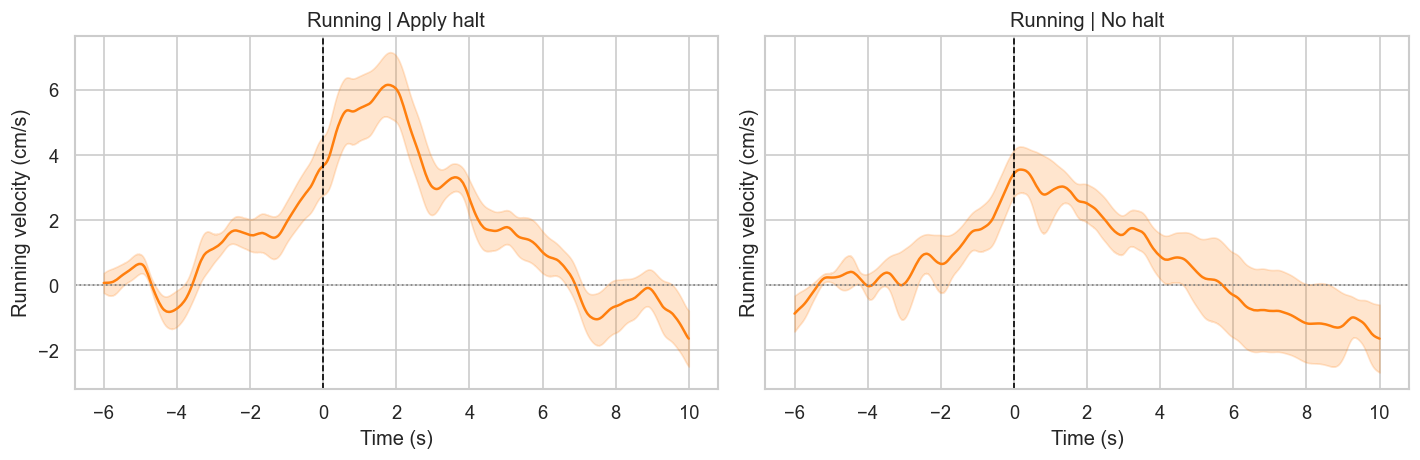

In [48]:
if running_avg_traces.empty:
    print("⚠️ Skipping running trace plots because no averaged traces are available.")
else:
    plot_groups = ["Apply halt", "No halt"]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    for ax, group_name in zip(axes, plot_groups):
        subset = running_avg_traces[running_avg_traces["group"] == group_name]
        if subset.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.axis("off")
            continue

        ax.plot(subset["time"], subset["mean_velocity"], color="#ff7f0e", linewidth=1.5)
        if "sem_velocity" in subset.columns:
            upper = subset["mean_velocity"] + subset["sem_velocity"].fillna(0)
            lower = subset["mean_velocity"] - subset["sem_velocity"].fillna(0)
            ax.fill_between(subset["time"], lower, upper, color="#ff7f0e", alpha=0.2)

        ax.axvline(0, color="black", linestyle="--", linewidth=1)
        ax.axhline(0, color="grey", linestyle=":", linewidth=1)
        ax.set_title(f"Running | {group_name}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Running velocity (cm/s)")

    plt.tight_layout()
    plt.show()

✅ Saved: running_metric_comparisons.pdf


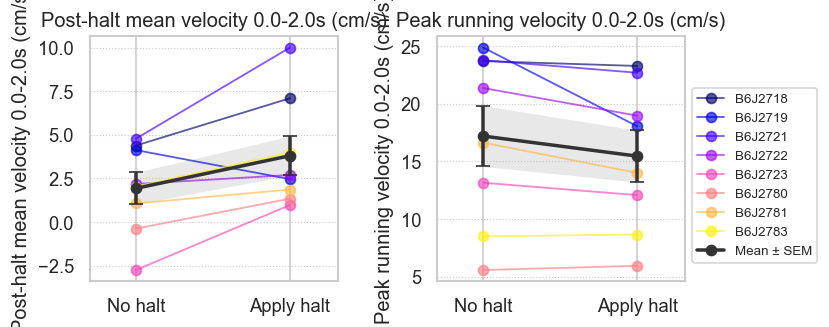

#### Running metrics paired t-tests

,n_pairs,mean_difference,t_statistic,p_value,metric,metric_label,group_a,group_b
0,8,1.870827,2.519206,0.039857,post_mean,Post-halt mean velocity 0.0-2.0s (cm/s),No halt,Apply halt
1,8,-1.742783,-2.120365,0.071683,peak_velocity_abs_1s,Peak running velocity 0.0-2.0s (cm/s),No halt,Apply halt


✅ Saved: running_metrics_ttests.csv
✅ Saved: running_metrics_combined.csv


In [49]:
# Running velocity comparisons (Apply halt vs No halt)
# ----------------------------------------------------------------------

running_metric_specs = [
    ("post_mean", f"Post-halt mean velocity {ANALYSIS_WINDOW_MEAN_PEAK[0]}-{ANALYSIS_WINDOW_MEAN_PEAK[1]}s (cm/s)"),
    ("peak_velocity_abs_1s", f"Peak running velocity {ANALYSIS_WINDOW_MEAN_PEAK[0]}-{ANALYSIS_WINDOW_MEAN_PEAK[1]}s (cm/s)"),
]
running_plot_groups = ["No halt", "Apply halt"]
running_stats_df = pd.DataFrame()

if running_metrics_combined.empty:
    print("⚠️ No per-mouse running velocity metrics available for comparison")
else:
    running_mouse_colors = assign_mouse_colors_consistent(running_metrics_combined["mouse"].dropna().unique())
    available_running_specs = [
        (metric, label)
        for metric, label in running_metric_specs
        if metric in running_metrics_combined.columns
    ]

    if not available_running_specs:
        print("⚠️ Running metrics not found in aggregated data")
    else:
        subplot_width_cm = 7.5
        subplot_height_cm = 7
        fig_width = len(available_running_specs) * subplot_width_cm / 2.54
        fig_height = subplot_height_cm / 2.54
        fig, axes = plt.subplots(
            1,
            len(available_running_specs),
            figsize=(fig_width, fig_height),
            sharey=False,
        )
        if len(available_running_specs) == 1:
            axes = [axes]

        mean_handles = []
        running_mouse_handles: Dict[str, object] = {}
        running_stats_records: List[Dict[str, object]] = []

        for ax, (metric, label) in zip(axes, available_running_specs):
            pivot = running_metrics_combined.pivot(index="mouse", columns="group", values=metric)
            groups_present = [group for group in running_plot_groups if group in pivot.columns]
            if len(groups_present) < 2:
                ax.text(0.5, 0.5, "Insufficient data", ha="center", va="center")
                ax.axis("off")
                continue

            group_a, group_b = groups_present[0], groups_present[1]
            stats_result = compute_paired_t_test(pivot, group_a, group_b)
            stats_result.update(
                {
                    "metric": metric,
                    "metric_label": label,
                    "group_a": group_a,
                    "group_b": group_b,
                }
            )
            running_stats_records.append(stats_result)

            x_positions = np.arange(len(groups_present), dtype=float)

            for mouse in pivot.index:
                values = pivot.loc[mouse, groups_present]
                if values.isna().all():
                    continue
                line, = ax.plot(
                    x_positions,
                    values.to_numpy(dtype=float),
                    marker="o",
                    linewidth=1.1,
                    alpha=0.65,
                    color=running_mouse_colors.get(mouse, "#1f77b4"),
                    zorder=2,
                )
                running_mouse_handles.setdefault(mouse, line)

            group_means = pivot[groups_present].mean(axis=0)
            group_sems = pivot[groups_present].apply(lambda col: sem(col.dropna()), axis=0)
            mean_values = group_means.to_numpy(dtype=float)
            sem_values = group_sems.to_numpy(dtype=float)
            valid_mask = np.isfinite(mean_values) & np.isfinite(sem_values)
            if valid_mask.any():
                x_valid = x_positions[valid_mask]
                mean_valid = mean_values[valid_mask]
                sem_valid = sem_values[valid_mask]
                ax.fill_between(
                    x_valid,
                    mean_valid - sem_valid,
                    mean_valid + sem_valid,
                    color="#b3b3b3",
                    alpha=0.3,
                    zorder=1,
                    linewidth=0,
                )

            error_container = ax.errorbar(
                x_positions,
                mean_values,
                yerr=sem_values,
                fmt="o-",
                color="#333333",
                linewidth=2.1,
                capsize=4,
                label="Mean ± SEM",
                zorder=3,
            )
            mean_handles.append(error_container)

            ax.set_xticks(x_positions)
            ax.set_xticklabels(groups_present)
            ax.set_xlim(-0.3, len(groups_present) - 1 + 0.31)
            ax.set_title(label)
            ax.set_ylabel(label)
            ax.grid(True, which="both", axis="y", linestyle=":", linewidth=0.7)

        legend_handles = list(running_mouse_handles.values())
        legend_labels = list(running_mouse_handles.keys())
        if mean_handles:
            legend_handles.append(mean_handles[0].lines[0])
            legend_labels.append("Mean ± SEM")
        if legend_handles:
            fig.legend(
                legend_handles,
                legend_labels,
                loc="center left",
                bbox_to_anchor=(0.85, 0.5),
                borderaxespad=0.0,
                frameon=True,
                fontsize=8,
            )

        fig.subplots_adjust(left=0, right=0.84, bottom=0.18, top=0.92, wspace=0.4)
        if OUTPUT_DIR is not None:
            fig.savefig(OUTPUT_DIR / "running_metric_comparisons.pdf", format="pdf", bbox_inches="tight")
            print(f"✅ Saved: running_metric_comparisons.pdf")
        plt.show()
        plt.close(fig)

        if running_stats_records:
            running_stats_df = pd.DataFrame(running_stats_records)
            display(Markdown("#### Running metrics paired t-tests"))
            display(running_stats_df)
            if OUTPUT_DIR is not None:
                running_stats_df.to_csv(OUTPUT_DIR / "running_metrics_ttests.csv", index=False)
                print(f"✅ Saved: running_metrics_ttests.csv")
        else:
            running_stats_df = pd.DataFrame()
        
        # Save running combined metrics
        if OUTPUT_DIR is not None and not running_metrics_combined.empty:
            running_metrics_combined.to_csv(OUTPUT_DIR / "running_metrics_combined.csv", index=False)
            print(f"✅ Saved: running_metrics_combined.csv")

### Eye tracking metrics (Saccade, Pupil, Eye Position) - Unified Analysis

**NOTE**: Eye position analysis keeps left/right turns separate because eye position 
direction matters. Saccade and pupil metrics are averaged across turn directions.

In [50]:
# Eye tracking analysis - Load all metrics together
# ----------------------------------------------------------------------

eye_tracking_records: List[Dict[str, object]] = []
eye_tracking_errors: Dict[str, List[str]] = {
    "saccade": [],
    "pupil": [],
    "eye_position": [],
}

# Define eye tracking metrics to load
# Format: (metric_name, column_name, display_name, direction_matters, is_absolute)
# - direction_matters: whether to separate left/right turns
# - is_absolute: whether values should be treated as absolute (probability, diameter) vs signed (position, velocity)
eye_metrics_config = [
    ("saccade", SACCADE_COLUMN, "Saccade Probability", False, True),  # ✓ COMBINED, ABSOLUTE (probability 0-1)
    ("pupil", PUPIL_COLUMN, "Pupil Diameter", False, True),           # ✓ COMBINED, ABSOLUTE (size always positive)
    ("eye_position", EYE_POSITION_COLUMN, "Eye Position (X)", True, False),  # × SEPARATED, SIGNED (position can be + or -)
]

# Optional: Check available columns in first CSV file (for debugging)
SHOW_AVAILABLE_COLUMNS = False  # Set to True to see what columns are in your CSV files

if not results_df.empty:
    n_files_processed = 0
    n_files_with_data = {"saccade": 0, "pupil": 0, "eye_position": 0}
    
    # Show available columns from first file (if requested)
    if SHOW_AVAILABLE_COLUMNS:
        first_csv = Path(results_df.iloc[0]["csv_path"])
        if first_csv.exists():
            first_df = pd.read_csv(first_csv)
            print(f"\n📋 Available columns in {first_csv.name}:")
            eye_related_cols = [col for col in first_df.columns if any(
                keyword in col.lower() for keyword in ["saccade", "pupil", "eye", "ellipse"]
            )]
            if eye_related_cols:
                print(f"   Eye-related columns found:")
                for col in eye_related_cols:
                    sample_vals = first_df[col].dropna().head(5)
                    if len(sample_vals) > 0:
                        print(f"      • {col}: range {sample_vals.min():.6f} to {sample_vals.max():.6f}")
            else:
                print(f"   No eye-related columns found. All columns:")
                for col in first_df.columns[:20]:  # Show first 20
                    print(f"      • {col}")
    
    for _, row in results_df.iterrows():
        csv_path = Path(row["csv_path"])
        n_files_processed += 1
        
        record = {
            "mouse": row["mouse"],
            "turn_label": row["direction"],
            "direction": row["direction"],  # Keep original direction
            "group": row["group"],
            "event_suffix": row["event_suffix"],
            "csv_path": row["csv_path"],
        }
        
        # Load all eye tracking metrics for this file
        for metric_name, column_name, display_name, direction_matters, is_absolute in eye_metrics_config:
            try:
                df = load_time_series(csv_path, TIME_COLUMN, column_name, value_alias="value")
                
                if df.empty:
                    raise ValueError(f"Empty dataframe after loading {column_name}")
                
                # For absolute metrics (probability, diameter), use absolute values
                # - Probability: Always 0-1, no negative values (treat as absolute magnitude)
                # - Diameter: Always positive (size measure)
                # For signed metrics (position), keep original sign
                # - Position: Can be left (-) or right (+) of center
                if is_absolute:
                    df["value"] = df["value"].abs()
                
                # Calculate pre and post means
                pre_mask = (df["time"] >= PRE_WINDOW[0]) & (df["time"] < PRE_WINDOW[1])
                post_mask = (df["time"] >= POST_WINDOW[0]) & (df["time"] < POST_WINDOW[1])
                
                pre_mean = float(df.loc[pre_mask, "value"].mean()) if pre_mask.any() else float("nan")
                post_mean = float(df.loc[post_mask, "value"].mean()) if post_mask.any() else float("nan")
                
                # Calculate peak value in analysis window
                peak_mask = (df["time"] >= ANALYSIS_WINDOW_MEAN_PEAK[0]) & (df["time"] <= ANALYSIS_WINDOW_MEAN_PEAK[1])
                if peak_mask.any():
                    if is_absolute:
                        peak_val = float(df.loc[peak_mask, "value"].max())  # Already absolute
                    else:
                        peak_val = float(df.loc[peak_mask, "value"].abs().max())  # Take abs for signed
                else:
                    peak_val = float("nan")
                
                # Add metrics with prefixes
                record[f"{metric_name}_pre_mean"] = pre_mean
                record[f"{metric_name}_post_mean"] = post_mean
                record[f"{metric_name}_peak"] = peak_val
                n_files_with_data[metric_name] += 1
                
            except Exception as exc:  # noqa: BLE001
                error_msg = f"{csv_path.name}: {exc}"
                eye_tracking_errors[metric_name].append(error_msg)
                record[f"{metric_name}_pre_mean"] = float("nan")
                record[f"{metric_name}_post_mean"] = float("nan")
                record[f"{metric_name}_peak"] = float("nan")
        
        eye_tracking_records.append(record)
    
    print(f"\n📊 Eye tracking data loading summary:")
    print(f"   Total files processed: {n_files_processed}")
    for metric_name in ["saccade", "pupil", "eye_position"]:
        n_success = n_files_with_data[metric_name]
        n_failed = len(eye_tracking_errors[metric_name])
        print(f"   {metric_name}: {n_success} succeeded, {n_failed} failed")

eye_tracking_df = pd.DataFrame(eye_tracking_records)

# Data range diagnostics - check if values are in expected ranges
if not eye_tracking_df.empty:
    print(f"\n📊 Data range diagnostics (raw values from CSV):")
    for metric_name in ["saccade", "pupil", "eye_position"]:
        post_col = f"{metric_name}_post_mean"
        if post_col in eye_tracking_df.columns:
            values = eye_tracking_df[post_col].dropna()
            if len(values) > 0:
                print(f"   {metric_name}_post_mean: min={values.min():.6f}, max={values.max():.6f}, mean={values.mean():.6f}")
                if metric_name == "saccade" and values.max() < 0.01:
                    print(f"      ⚠️ WARNING: Saccade probability values are very small (< 0.01)")
                    print(f"      ⚠️ This might be per-frame probability, or the data may need different column")
                    print(f"      ⚠️ Expected range: 0-1 for probability, but found: {values.min():.6f}-{values.max():.6f}")

# Save combined eye tracking results
if OUTPUT_DIR is not None and not eye_tracking_df.empty:
    eye_tracking_df.to_csv(OUTPUT_DIR / "eye_tracking_metrics_per_file.csv", index=False)
    print(f"✅ Saved: eye_tracking_metrics_per_file.csv")

eye_tracking_df


📊 Eye tracking data loading summary:
   Total files processed: 30
   saccade: 30 succeeded, 0 failed
   pupil: 26 succeeded, 4 failed
   eye_position: 26 succeeded, 4 failed

📊 Data range diagnostics (raw values from CSV):
   saccade_post_mean: min=0.000000, max=0.000857, mean=0.000414
      ⚠️ WARNING: Saccade probability values are very small (< 0.01)
      ⚠️ This might be per-frame probability, or the data may need different column
      ⚠️ Expected range: 0-1 for probability, but found: 0.000000-0.000857
   pupil_post_mean: min=0.535261, max=3.775472, mean=1.685293
   eye_position_post_mean: min=-5.677504, max=8.782086, mean=0.479482
✅ Saved: eye_tracking_metrics_per_file.csv


,mouse,turn_label,direction,group,event_suffix,csv_path,saccade_pre_mean,saccade_post_mean,saccade_peak,pupil_pre_mean,pupil_post_mean,pupil_peak,eye_position_pre_mean,eye_position_post_mean,eye_position_peak
0,B6J2718,right,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.000565,0.000630,0.004,1.777689,2.734592,8.372411,-6.614244,-5.677504,28.223330
1,B6J2718,left,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.000846,0.000423,0.002,1.229073,1.929037,6.765074,3.592427,-0.457948,22.450106
2,B6J2718,right,right,No halt,_No halt_right_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.000958,0.000604,0.002,1.524286,1.466365,6.104841,-3.742190,0.851092,26.431195
3,B6J2718,left,left,No halt,_No halt_left_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.000720,0.000420,0.004,1.343439,1.501698,4.449636,2.930418,0.256703,22.295279
4,B6J2719,right,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.000857,0.000857,0.004,2.541098,3.775472,8.135715,-4.459847,1.175353,30.856315
5,B6J2719,left,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.000333,0.000333,0.002,1.360678,1.347965,3.175579,3.577594,0.710986,21.606638
6,B6J2719,right,right,No halt,_No halt_right_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.001235,0.000706,0.004,2.680098,2.869137,10.793496,-7.338890,-3.404804,37.290352
7,B6J2719,left,left,No halt,_No halt_left_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.001000,0.000778,0.004,2.012441,2.591057,6.837702,4.459418,1.409524,32.512668
8,B6J2721,right,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.000591,0.000273,0.002,1.227222,1.760108,5.618389,-0.916508,-1.442055,19.982076
9,B6J2721,left,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/V...,0.000714,0.000357,0.002,1.037516,2.023537,4.915270,3.498939,-0.094310,11.972814


In [51]:
# Report eye tracking loading errors
# ----------------------------------------------------------------------

total_errors = sum(len(errors) for errors in eye_tracking_errors.values())
if total_errors > 0:
    print(f"\n⚠️ Eye tracking loading errors details:")
    for metric_name, errors in eye_tracking_errors.items():
        if errors:
            print(f"\n  {metric_name.upper()}: {len(errors)} files failed")
            # Show first 3 errors
            for i, error in enumerate(errors[:3]):
                print(f"    {i+1}. {error}")
            if len(errors) > 3:
                print(f"    ... and {len(errors)-3} more")
else:
    print(f"✅ All eye tracking metrics loaded successfully!")


⚠️ Eye tracking loading errors details:

  PUPIL: 4 files failed
    1. B6J2723_Apply halt_2s_right_turns_baselined_data.csv: Column 'Pupil.Diameter_eye1_Baseline' not found in /Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/Visual_mismatch_day3/B6J2723-2024-12-10T15-36-13_processedData/aligned_data/B6J2723_Apply halt_2s_right_turns_baselined_data.csv
    2. B6J2723_Apply halt_2s_left_turns_baselined_data.csv: Column 'Pupil.Diameter_eye1_Baseline' not found in /Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/Visual_mismatch_day3/B6J2723-2024-12-10T15-36-13_processedData/aligned_data/B6J2723_Apply halt_2s_left_turns_baselined_data.csv
    3. B6J2723_No halt_right_turns_baselined_data.csv: Column 'Pupil.Diameter_eye1_Baseline' not found in /Volumes/RanczLab2/DATA_NEW/Cohort1_rotation/Visual_mismatch_day3/B6J2723-2024-12-10T15-36-13_processedData/aligned_data/B6J2723_No halt_right_turns_baselined_data.csv
    ... and 1 more

  EYE_POSITION: 4 files failed
    1. B6J2723_Apply halt_2s_right_turn

In [52]:
# Aggregate eye tracking metrics per mouse
# ----------------------------------------------------------------------
# For saccade and pupil: average across all turns
# For eye_position: keep left and right turns SEPARATE

if eye_tracking_df.empty:
    eye_tracking_per_mouse = pd.DataFrame()
    eye_position_per_mouse = pd.DataFrame()
else:
    # Saccade and Pupil: aggregate across ALL turns (direction doesn't matter)
    saccade_pupil_cols = {
        "saccade_post_mean": "mean",
        "saccade_peak": "mean",
        "pupil_post_mean": "mean",
        "pupil_peak": "mean",
    }
    # Only aggregate columns that exist
    saccade_pupil_cols = {k: v for k, v in saccade_pupil_cols.items() if k in eye_tracking_df.columns}
    
    if saccade_pupil_cols:
        eye_tracking_per_mouse = eye_tracking_df.groupby(["group", "mouse"], dropna=False).agg(
            saccade_pupil_cols
        ).reset_index()
    else:
        eye_tracking_per_mouse = pd.DataFrame()
    
    # Eye Position: keep direction SEPARATE (left vs right turns matter!)
    eye_position_cols = {
        "eye_position_post_mean": "mean",
        "eye_position_peak": "mean",
    }
    eye_position_cols = {k: v for k, v in eye_position_cols.items() if k in eye_tracking_df.columns}
    
    if eye_position_cols:
        eye_position_per_mouse = eye_tracking_df.groupby(
            ["group", "mouse", "direction"], dropna=False
        ).agg(eye_position_cols).reset_index()
    else:
        eye_position_per_mouse = pd.DataFrame()
    
    # Save per-mouse aggregated metrics
    if OUTPUT_DIR is not None:
        if not eye_tracking_per_mouse.empty:
            eye_tracking_per_mouse.to_csv(OUTPUT_DIR / "saccade_pupil_metrics_per_mouse.csv", index=False)
            print(f"✅ Saved: saccade_pupil_metrics_per_mouse.csv")
        if not eye_position_per_mouse.empty:
            eye_position_per_mouse.to_csv(OUTPUT_DIR / "eye_position_metrics_per_mouse.csv", index=False)
            print(f"✅ Saved: eye_position_metrics_per_mouse.csv")

print("\n📊 Saccade & Pupil metrics (averaged across turn directions):")
display(eye_tracking_per_mouse if not eye_tracking_per_mouse.empty else "No data")

print("\n📊 Eye Position metrics (separated by turn direction):")
display(eye_position_per_mouse if not eye_position_per_mouse.empty else "No data")

✅ Saved: saccade_pupil_metrics_per_mouse.csv
✅ Saved: eye_position_metrics_per_mouse.csv

📊 Saccade & Pupil metrics (averaged across turn directions):


,group,mouse,saccade_post_mean,saccade_peak,pupil_post_mean,pupil_peak
0,Apply halt,B6J2718,0.000527,0.003,2.331815,7.568743
1,Apply halt,B6J2719,0.000595,0.003,2.561719,5.655647
2,Apply halt,B6J2721,0.000315,0.002,1.891822,5.266829
3,Apply halt,B6J2722,0.000202,0.002,1.595184,5.242945
4,Apply halt,B6J2723,0.000000,0.000,NaN,NaN
5,Apply halt,B6J2780,0.000250,0.004,1.817933,3.871766
6,Apply halt,B6J2781,0.000307,0.002,1.977760,5.528852
7,Apply halt,B6J2783,0.000250,0.002,0.924842,2.380164
8,No halt,B6J2718,0.000512,0.003,1.484032,5.277239
9,No halt,B6J2719,0.000742,0.004,2.730097,8.815599



📊 Eye Position metrics (separated by turn direction):


,group,mouse,direction,eye_position_post_mean,eye_position_peak
0,Apply halt,B6J2718,left,-0.457948,22.450106
1,Apply halt,B6J2718,right,-5.677504,28.223330
2,Apply halt,B6J2719,left,0.710986,21.606638
3,Apply halt,B6J2719,right,1.175353,30.856315
4,Apply halt,B6J2721,left,-0.094310,11.972814
5,Apply halt,B6J2721,right,-1.442055,19.982076
6,Apply halt,B6J2722,left,2.477665,20.315179
7,Apply halt,B6J2722,right,-1.011584,10.259943
8,Apply halt,B6J2723,left,NaN,NaN
9,Apply halt,B6J2723,right,NaN,NaN


In [53]:
# Load time traces for all eye tracking metrics for plotting
# ----------------------------------------------------------------------

eye_trace_records = {
    "saccade": [],
    "pupil": [],
    "eye_position": [],
}

if not results_df.empty:
    n_traces_loaded = {"saccade": 0, "pupil": 0, "eye_position": 0}
    
    for _, row in results_df.iterrows():
        csv_path = Path(row["csv_path"])
        
        for metric_name, column_name, display_name, direction_matters, is_absolute in eye_metrics_config:
            try:
                df = load_time_series(csv_path, TIME_COLUMN, column_name, value_alias="value")
                
                if df.empty:
                    continue
                
                # For absolute metrics (probability, diameter), use absolute values
                if is_absolute:
                    df["value"] = df["value"].abs()
                
                df["group"] = row["group"]
                df["mouse"] = row["mouse"]
                df["direction"] = row["direction"]  # Keep direction info
                df["metric"] = display_name
                eye_trace_records[metric_name].append(df)
                n_traces_loaded[metric_name] += 1
                
            except Exception as exc:  # noqa: BLE001
                # Silently skip - errors already reported in the loading section
                continue
    
    print(f"\n📊 Time traces loaded:")
    for metric_name in ["saccade", "pupil", "eye_position"]:
        print(f"   {metric_name}: {n_traces_loaded[metric_name]} traces")

# Create trace dataframes
eye_traces = {}
for metric_name in ["saccade", "pupil", "eye_position"]:
    if eye_trace_records[metric_name]:
        eye_traces[metric_name] = pd.concat(eye_trace_records[metric_name], ignore_index=True)
        print(f"   ✅ {metric_name}: {len(eye_traces[metric_name])} total data points")
    else:
        eye_traces[metric_name] = pd.DataFrame()
        print(f"   ⚠️ {metric_name}: No data available")


📊 Time traces loaded:
   saccade: 30 traces
   pupil: 26 traces
   eye_position: 26 traces
   ✅ saccade: 7696481 total data points
   ✅ pupil: 6909901 total data points
   ✅ eye_position: 6909901 total data points


In [54]:
# Compute averaged traces for each eye metric
# ----------------------------------------------------------------------
# NOTE: Saccade and Pupil average across ALL turns (left + right)
#       Eye Position keeps left and right turns SEPARATE

eye_avg_traces = {}

for metric_name, column_name, display_name, direction_matters, is_absolute in eye_metrics_config:
    if not eye_traces[metric_name].empty:
        if direction_matters:
            # Eye position: keep direction separate
            # Per-mouse average first (within each direction)
            per_mouse = (
                eye_traces[metric_name]
                .groupby(["group", "mouse", "direction", "time"], dropna=False)["value"]
                .mean()
                .reset_index()
            )
            
            # Then average across mice (within each direction)
            avg_trace = (
                per_mouse
                .groupby(["group", "direction", "time"], dropna=False)
                .agg(
                    mean_value=("value", "mean"),
                    sem_value=("value", lambda x: sem(x) if len(x.dropna()) > 1 else 0.0),
                    n_mice=("mouse", "nunique"),
                )
                .reset_index()
            )
        else:
            # Saccade and Pupil: average across ALL turns
            # Per-mouse average first
            per_mouse = (
                eye_traces[metric_name]
                .groupby(["group", "mouse", "time"], dropna=False)["value"]
                .mean()
                .reset_index()
            )
            
            # Then average across mice
            avg_trace = (
                per_mouse
                .groupby(["group", "time"], dropna=False)
                .agg(
                    mean_value=("value", "mean"),
                    sem_value=("value", lambda x: sem(x) if len(x.dropna()) > 1 else 0.0),
                    n_mice=("mouse", "nunique"),
                )
                .reset_index()
            )
        
        avg_trace["metric"] = display_name
        avg_trace["is_absolute"] = is_absolute  # Store for reference
        eye_avg_traces[metric_name] = avg_trace
        print(f"   ✅ Computed avg traces for {metric_name}: {len(avg_trace)} time points")
    else:
        eye_avg_traces[metric_name] = pd.DataFrame()
        print(f"   ⚠️ No traces to average for {metric_name}")

# Save averaged traces with more descriptive column names
if OUTPUT_DIR is not None:
    n_saved = 0
    for metric_name, df in eye_avg_traces.items():
        if not df.empty:
            # Rename columns for clarity in CSV output
            df_save = df.copy()
            
            # Rename based on metric type for better readability
            if metric_name == "saccade":
                df_save = df_save.rename(columns={
                    "mean_value": "mean_probability",
                    "sem_value": "sem_probability"
                })
            elif metric_name == "pupil":
                df_save = df_save.rename(columns={
                    "mean_value": "mean_diameter",
                    "sem_value": "sem_diameter"
                })
            elif metric_name == "eye_position":
                df_save = df_save.rename(columns={
                    "mean_value": "mean_position",
                    "sem_value": "sem_position"
                })
            
            df_save.to_csv(OUTPUT_DIR / f"eye_{metric_name}_avg_traces.csv", index=False)
            print(f"✅ Saved: eye_{metric_name}_avg_traces.csv ({len(df_save)} rows)")
            n_saved += 1
    if n_saved == 0:
        print("⚠️ No averaged traces to save (all dataframes empty)")

   ✅ Computed avg traces for saccade: 32002 time points
   ✅ Computed avg traces for pupil: 32002 time points
   ✅ Computed avg traces for eye_position: 64004 time points
✅ Saved: eye_saccade_avg_traces.csv (32002 rows)
✅ Saved: eye_pupil_avg_traces.csv (32002 rows)
✅ Saved: eye_eye_position_avg_traces.csv (64004 rows)


✅ Saved: /Volumes/RanczLab2/DATA_NEW/turning_analysis__Cohort1_rotation_Visual_mismatch_day3__Cohort3_rotation_Visual_mismatch_day3/eye_tracking_avg_traces.pdf


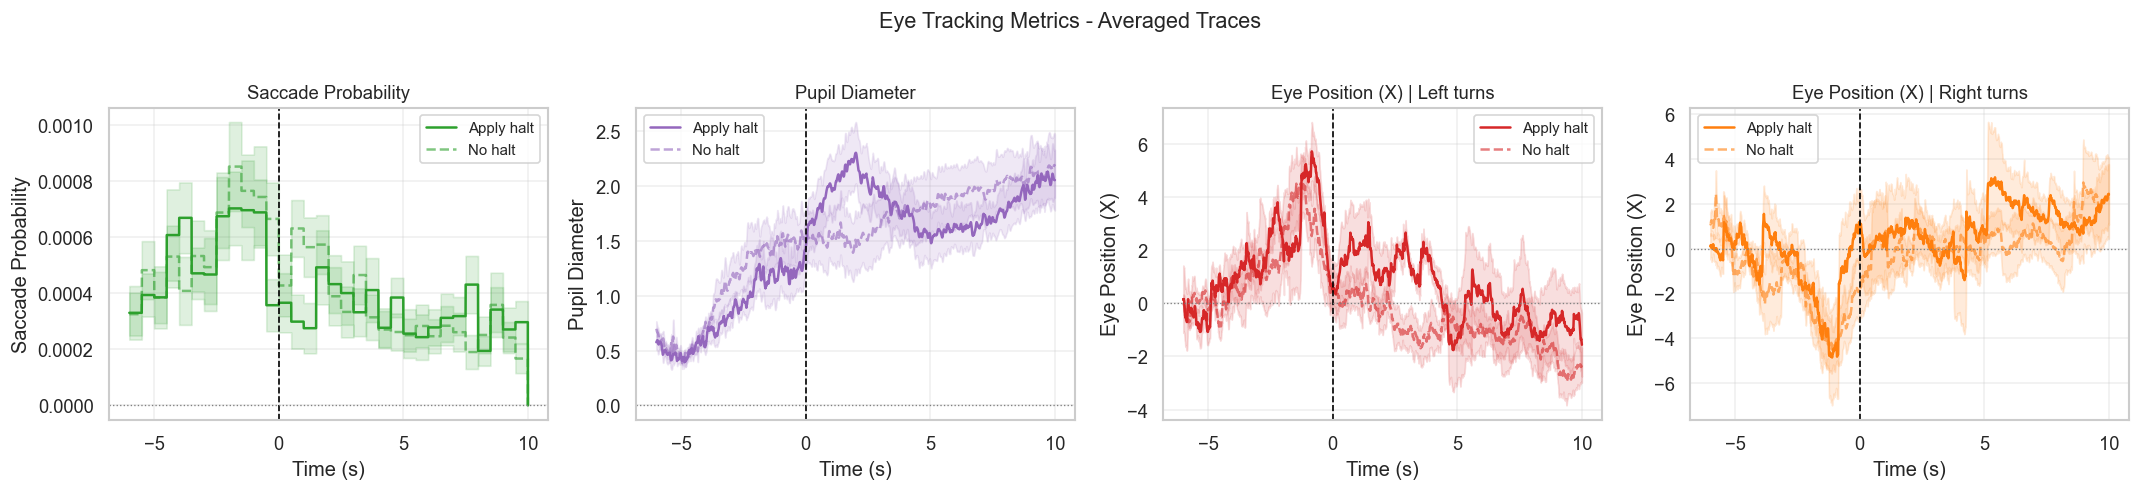

In [55]:
# Plot averaged traces for all eye metrics
# ----------------------------------------------------------------------
# Saccade and Pupil: 1 panel each (averaged across turns)
# Eye Position: 2 panels (left and right turns separate)

plot_colors = {
    "saccade": "#2ca02c",      # Green
    "pupil": "#9467bd",        # Purple  
    "eye_position_left": "#d62728",   # Red
    "eye_position_right": "#ff7f0e",  # Orange
}

plot_labels = {
    "saccade": "Saccade Probability",
    "pupil": "Pupil Diameter",
    "eye_position": "Eye Position (X)",
}

if any(not df.empty for df in eye_avg_traces.values()):
    # Create figure with 4 subplots: saccade, pupil, eye_pos_left, eye_pos_right
    fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=False)
    
    plot_idx = 0
    
    # Plot Saccade and Pupil (averaged across turns)
    for metric_name in ["saccade", "pupil"]:
        ax = axes[plot_idx]
        avg_df = eye_avg_traces[metric_name]
        
        if avg_df.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            ax.set_title(plot_labels[metric_name])
            ax.axis("off")
            plot_idx += 1
            continue
        
        # Plot for each group
        for group_name in ["Apply halt", "No halt"]:
            subset = avg_df[avg_df["group"] == group_name]
            if subset.empty:
                continue
            
            color = plot_colors[metric_name]
            alpha = 1.0 if group_name == "Apply halt" else 0.6
            linestyle = "-" if group_name == "Apply halt" else "--"
            
            ax.plot(subset["time"], subset["mean_value"], 
                   color=color, linewidth=1.5, alpha=alpha, linestyle=linestyle,
                   label=group_name)
            
            if "sem_value" in subset.columns:
                upper = subset["mean_value"] + subset["sem_value"].fillna(0)
                lower = subset["mean_value"] - subset["sem_value"].fillna(0)
                ax.fill_between(subset["time"], lower, upper, 
                               color=color, alpha=0.15)
        
        ax.axvline(0, color="black", linestyle="--", linewidth=1)
        ax.axhline(0, color="grey", linestyle=":", linewidth=0.8)
        ax.set_title(plot_labels[metric_name], fontsize=11)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel(plot_labels[metric_name])
        ax.legend(fontsize=9, loc='best')
        ax.grid(True, alpha=0.3)
        plot_idx += 1
    
    # Plot Eye Position (separate for left and right turns)
    eye_pos_df = eye_avg_traces.get("eye_position", pd.DataFrame())
    
    for turn_direction in ["left", "right"]:
        ax = axes[plot_idx]
        
        if eye_pos_df.empty or "direction" not in eye_pos_df.columns:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            ax.set_title(f"Eye Position | {turn_direction.capitalize()}")
            ax.axis("off")
            plot_idx += 1
            continue
        
        direction_data = eye_pos_df[eye_pos_df["direction"] == turn_direction]
        
        if direction_data.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            ax.set_title(f"Eye Position | {turn_direction.capitalize()}")
            ax.axis("off")
            plot_idx += 1
            continue
        
        # Plot for each group
        for group_name in ["Apply halt", "No halt"]:
            subset = direction_data[direction_data["group"] == group_name]
            if subset.empty:
                continue
            
            color = plot_colors[f"eye_position_{turn_direction}"]
            alpha = 1.0 if group_name == "Apply halt" else 0.6
            linestyle = "-" if group_name == "Apply halt" else "--"
            
            ax.plot(subset["time"], subset["mean_value"], 
                   color=color, linewidth=1.5, alpha=alpha, linestyle=linestyle,
                   label=group_name)
            
            if "sem_value" in subset.columns:
                upper = subset["mean_value"] + subset["sem_value"].fillna(0)
                lower = subset["mean_value"] - subset["sem_value"].fillna(0)
                ax.fill_between(subset["time"], lower, upper, 
                               color=color, alpha=0.15)
        
        ax.axvline(0, color="black", linestyle="--", linewidth=1)
        ax.axhline(0, color="grey", linestyle=":", linewidth=0.8)
        ax.set_title(f"Eye Position (X) | {turn_direction.capitalize()} turns", fontsize=11)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Eye Position (X)")
        ax.legend(fontsize=9, loc='best')
        ax.grid(True, alpha=0.3)
        plot_idx += 1
    
    plt.suptitle("Eye Tracking Metrics - Averaged Traces", fontsize=13, y=1.02)
    plt.tight_layout()
    
    if OUTPUT_DIR is not None:
        output_path = OUTPUT_DIR / "eye_tracking_avg_traces.pdf"
        fig.savefig(output_path, format="pdf", bbox_inches="tight")
        print(f"✅ Saved: {output_path}")
    
    plt.show()
    plt.close(fig)
else:
    print("⚠️ No eye tracking traces available for plotting")

✅ Saved: saccade_pupil_metric_comparisons.pdf


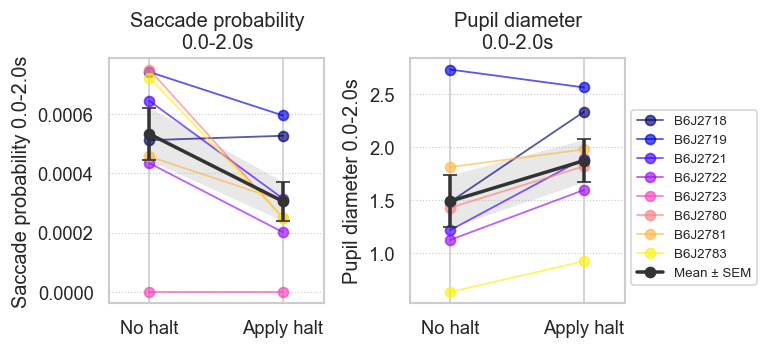

#### Saccade & Pupil metrics paired t-tests

,n_pairs,mean_difference,t_statistic,p_value,metric,metric_label,group_a,group_b
0,8,-0.000227,-3.284858,0.013397,saccade_post_mean,Saccade probability 0.0-2.0s,No halt,Apply halt
1,7,0.381420,3.025351,0.023237,pupil_post_mean,Pupil diameter 0.0-2.0s,No halt,Apply halt


✅ Saved: saccade_pupil_metrics_ttests.csv


In [56]:
# Combined comparison plot: Saccade & Pupil (Apply halt vs No halt)
# ----------------------------------------------------------------------

eye_metric_specs = [
    ("saccade_post_mean", f"Saccade probability\n{ANALYSIS_WINDOW_MEAN_PEAK[0]}-{ANALYSIS_WINDOW_MEAN_PEAK[1]}s"),
    ("pupil_post_mean", f"Pupil diameter\n{ANALYSIS_WINDOW_MEAN_PEAK[0]}-{ANALYSIS_WINDOW_MEAN_PEAK[1]}s"),
]
eye_plot_groups = ["No halt", "Apply halt"]
eye_tracking_stats_df = pd.DataFrame()

if eye_tracking_per_mouse.empty:
    print("⚠️ No per-mouse saccade/pupil metrics available for comparison")
else:
    eye_mouse_colors = assign_mouse_colors_consistent(eye_tracking_per_mouse["mouse"].dropna().unique())
    
    subplot_width_cm = 6.5
    subplot_height_cm = 7
    fig_width = len(eye_metric_specs) * subplot_width_cm / 2.54
    fig_height = subplot_height_cm / 2.54
    fig, axes = plt.subplots(1, len(eye_metric_specs), figsize=(fig_width, fig_height), sharey=False)
    
    mean_handles = []
    eye_mouse_handles: Dict[str, object] = {}
    eye_stats_records: List[Dict[str, object]] = []
    
    for ax, (metric, label) in zip(axes, eye_metric_specs):
        pivot = eye_tracking_per_mouse.pivot(index="mouse", columns="group", values=metric)
        groups_present = [group for group in eye_plot_groups if group in pivot.columns]
        
        if len(groups_present) < 2:
            ax.text(0.5, 0.5, "Insufficient data", ha="center", va="center")
            ax.axis("off")
            continue
        
        group_a, group_b = groups_present[0], groups_present[1]
        stats_result = compute_paired_t_test(pivot, group_a, group_b)
        stats_result.update({
            "metric": metric,
            "metric_label": label.replace('\n', ' '),
            "group_a": group_a,
            "group_b": group_b,
        })
        eye_stats_records.append(stats_result)
        
        x_positions = np.arange(len(groups_present), dtype=float)
        
        # Plot individual mice
        for mouse in pivot.index:
            values = pivot.loc[mouse, groups_present]
            if values.isna().all():
                continue
            line, = ax.plot(
                x_positions,
                values.to_numpy(dtype=float),
                marker="o",
                linewidth=1.1,
                alpha=0.65,
                color=eye_mouse_colors.get(mouse, "#1f77b4"),
                zorder=2,
            )
            eye_mouse_handles.setdefault(mouse, line)
        
        # Plot group means
        group_means = pivot[groups_present].mean(axis=0)
        group_sems = pivot[groups_present].apply(lambda col: sem(col.dropna()), axis=0)
        mean_values = group_means.to_numpy(dtype=float)
        sem_values = group_sems.to_numpy(dtype=float)
        
        valid_mask = np.isfinite(mean_values) & np.isfinite(sem_values)
        if valid_mask.any():
            x_valid = x_positions[valid_mask]
            mean_valid = mean_values[valid_mask]
            sem_valid = sem_values[valid_mask]
            ax.fill_between(
                x_valid,
                mean_valid - sem_valid,
                mean_valid + sem_valid,
                color="#b3b3b3",
                alpha=0.3,
                zorder=1,
                linewidth=0,
            )
        
        error_container = ax.errorbar(
            x_positions,
            mean_values,
            yerr=sem_values,
            fmt="o-",
            color="#333333",
            linewidth=2.1,
            capsize=4,
            label="Mean ± SEM",
            zorder=3,
        )
        mean_handles.append(error_container)
        
        ax.set_xticks(x_positions)
        ax.set_xticklabels(groups_present)
        ax.set_xlim(-0.3, len(groups_present) - 1 + 0.31)
        ax.set_title(label)
        ax.set_ylabel(label.replace('\n', ' '))
        ax.grid(True, which="both", axis="y", linestyle=":", linewidth=0.7)
    
    # Add legend
    legend_handles = list(eye_mouse_handles.values())
    legend_labels = list(eye_mouse_handles.keys())
    if mean_handles:
        legend_handles.append(mean_handles[0].lines[0])
        legend_labels.append("Mean ± SEM")
    if legend_handles:
        fig.legend(
            legend_handles,
            legend_labels,
            loc="center left",
            bbox_to_anchor=(0.85, 0.5),
            borderaxespad=0.0,
            frameon=True,
            fontsize=8,
        )
    
    fig.subplots_adjust(left=0, right=0.84, bottom=0.18, top=0.92, wspace=0.4)
    if OUTPUT_DIR is not None:
        fig.savefig(OUTPUT_DIR / "saccade_pupil_metric_comparisons.pdf", format="pdf", bbox_inches="tight")
        print(f"✅ Saved: saccade_pupil_metric_comparisons.pdf")
    plt.show()
    plt.close(fig)
    
    # Save statistics
    if eye_stats_records:
        eye_tracking_stats_df = pd.DataFrame(eye_stats_records)
        display(Markdown("#### Saccade & Pupil metrics paired t-tests"))
        display(eye_tracking_stats_df)
        if OUTPUT_DIR is not None:
            eye_tracking_stats_df.to_csv(OUTPUT_DIR / "saccade_pupil_metrics_ttests.csv", index=False)
            print(f"✅ Saved: saccade_pupil_metrics_ttests.csv")


📊 Eye position comparison (separated by turn direction)
✅ Saved: eye_position_metric_comparisons.pdf


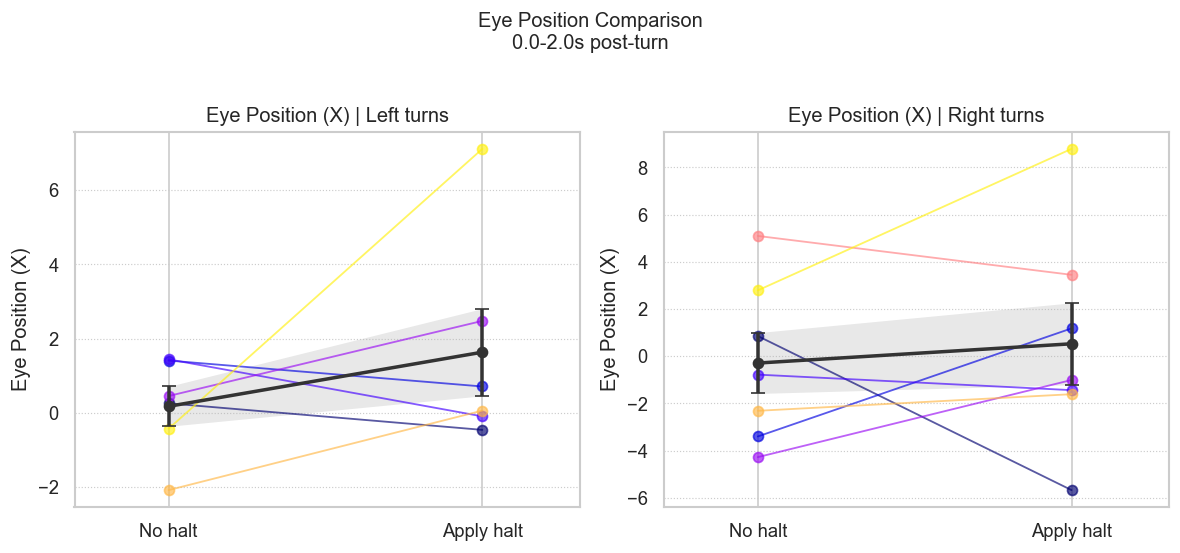

#### Eye position metrics paired t-tests (by turn direction)

,n_pairs,mean_difference,t_statistic,p_value,metric,metric_label,direction,group_a,group_b
0,6,1.458884,1.066796,0.334842,eye_position_post_mean_left,Eye position (X) | left turns,left,No halt,Apply halt
1,7,0.816501,0.506343,0.630679,eye_position_post_mean_right,Eye position (X) | right turns,right,No halt,Apply halt


✅ Saved: eye_position_metrics_ttests.csv


In [57]:
# Eye Position comparison plot (Apply halt vs No halt, separated by turn direction)
# ----------------------------------------------------------------------

eye_position_metric_specs = [
    ("eye_position_post_mean", f"Eye position (X)\n{ANALYSIS_WINDOW_MEAN_PEAK[0]}-{ANALYSIS_WINDOW_MEAN_PEAK[1]}s"),
]
eye_position_stats_df = pd.DataFrame()

if eye_position_per_mouse.empty:
    print("⚠️ No per-mouse eye position metrics available for comparison")
else:
    print(f"\n📊 Eye position comparison (separated by turn direction)")
    
    # Create separate plots for left and right turns
    fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), sharey=False)
    
    eye_pos_mouse_colors = assign_mouse_colors_consistent(eye_position_per_mouse["mouse"].dropna().unique())
    eye_pos_stats_records = []
    
    for ax, turn_direction in zip(axes, ["left", "right"]):
        direction_data = eye_position_per_mouse[eye_position_per_mouse["direction"] == turn_direction]
        
        if direction_data.empty:
            ax.text(0.5, 0.5, f"No data for {turn_direction} turns", ha="center", va="center")
            ax.axis("off")
            continue
        
        metric = "eye_position_post_mean"
        pivot = direction_data.pivot(index="mouse", columns="group", values=metric)
        groups_present = [group for group in eye_plot_groups if group in pivot.columns]
        
        if len(groups_present) < 2:
            ax.text(0.5, 0.5, "Insufficient data", ha="center", va="center")
            ax.axis("off")
            continue
        
        # Compute statistics
        group_a, group_b = groups_present[0], groups_present[1]
        stats_result = compute_paired_t_test(pivot, group_a, group_b)
        stats_result.update({
            "metric": f"eye_position_post_mean_{turn_direction}",
            "metric_label": f"Eye position (X) | {turn_direction} turns",
            "direction": turn_direction,
            "group_a": group_a,
            "group_b": group_b,
        })
        eye_pos_stats_records.append(stats_result)
        
        x_positions = np.arange(len(groups_present), dtype=float)
        
        # Plot individual mice
        for mouse in pivot.index:
            values = pivot.loc[mouse, groups_present]
            if values.isna().all():
                continue
            ax.plot(
                x_positions,
                values.to_numpy(dtype=float),
                marker="o",
                linewidth=1.1,
                alpha=0.65,
                color=eye_pos_mouse_colors.get(mouse, "#1f77b4"),
                zorder=2,
            )
        
        # Plot group means
        group_means = pivot[groups_present].mean(axis=0)
        group_sems = pivot[groups_present].apply(lambda col: sem(col.dropna()), axis=0)
        mean_values = group_means.to_numpy(dtype=float)
        sem_values = group_sems.to_numpy(dtype=float)
        
        valid_mask = np.isfinite(mean_values) & np.isfinite(sem_values)
        if valid_mask.any():
            x_valid = x_positions[valid_mask]
            mean_valid = mean_values[valid_mask]
            sem_valid = sem_values[valid_mask]
            ax.fill_between(
                x_valid,
                mean_valid - sem_valid,
                mean_valid + sem_valid,
                color="#b3b3b3",
                alpha=0.3,
                zorder=1,
                linewidth=0,
            )
        
        ax.errorbar(
            x_positions,
            mean_values,
            yerr=sem_values,
            fmt="o-",
            color="#333333",
            linewidth=2.1,
            capsize=4,
            label="Mean ± SEM",
            zorder=3,
        )
        
        ax.set_xticks(x_positions)
        ax.set_xticklabels(groups_present)
        ax.set_xlim(-0.3, len(groups_present) - 1 + 0.31)
        ax.set_title(f"Eye Position (X) | {turn_direction.capitalize()} turns")
        ax.set_ylabel("Eye Position (X)")
        ax.grid(True, which="both", axis="y", linestyle=":", linewidth=0.7)
    
    plt.suptitle(f"Eye Position Comparison\n{ANALYSIS_WINDOW_MEAN_PEAK[0]}-{ANALYSIS_WINDOW_MEAN_PEAK[1]}s post-turn", 
                 fontsize=12, y=1.02)
    plt.tight_layout()
    
    if OUTPUT_DIR is not None:
        fig.savefig(OUTPUT_DIR / "eye_position_metric_comparisons.pdf", format="pdf", bbox_inches="tight")
        print(f"✅ Saved: eye_position_metric_comparisons.pdf")
    plt.show()
    plt.close(fig)
    
    # Save statistics
    if eye_pos_stats_records:
        eye_position_stats_df = pd.DataFrame(eye_pos_stats_records)
        display(Markdown("#### Eye position metrics paired t-tests (by turn direction)"))
        display(eye_position_stats_df)
        if OUTPUT_DIR is not None:
            eye_position_stats_df.to_csv(OUTPUT_DIR / "eye_position_metrics_ttests.csv", index=False)
            print(f"✅ Saved: eye_position_metrics_ttests.csv")

### Turning velocity summary


In [58]:
# TURNING Summary statistics
# ----------------------------------------------------------------------

summary_df = summarise_results(results_df)
if summary_df.empty:
    print("⚠️ No summary statistics available")
else:
    for group_name, subdf in summary_df.groupby("group", dropna=False):
        title = group_name if isinstance(group_name, str) else "Unknown"
        display(Markdown(f"### {title}"))
        display(subdf.drop(columns=["group"], errors="ignore").reset_index(drop=True))

### Apply halt

,direction,expected_sign,n_files,n_mice,mean_post_velocity,fraction_direction_change
0,left,1,7,7,-6.459676,0.00
1,right,-1,8,8,3.011684,0.25


### No halt

,direction,expected_sign,n_files,n_mice,mean_post_velocity,fraction_direction_change
0,left,1,7,7,-6.224791,0.143
1,right,-1,8,8,4.374591,0.250


In [59]:
# Turn timing and magnitude metrics
# ----------------------------------------------------------------------

if results_df.empty:
    timing_summary_df = pd.DataFrame()
    timing_mouse_df = pd.DataFrame()

In [60]:
# Turn timing and magnitude metrics
# ----------------------------------------------------------------------

if results_df.empty:
    timing_summary_df = pd.DataFrame()
    timing_mouse_df = pd.DataFrame()
else:
    timing_columns = [
        "time_to_peak",
        "latency_to_fraction_peak",
        "peak_velocity_magnitude",
        "peak_velocity_abs_1s",
        "auc_abs",
        "decay_tau",
    ]
    timing_columns = [column for column in timing_columns if column in results_df.columns]
    if timing_columns:
        timing_summary_df = (
            results_df.groupby(["group", "direction"], dropna=False)[timing_columns]
            .agg(["mean", "sem"])
        )
        timing_summary_df.columns = [f"{metric}_{stat}" for metric, stat in timing_summary_df.columns]
        timing_summary_df = timing_summary_df.reset_index()

        timing_mouse_df = (
            results_df.groupby(["group", "mouse", "direction"], dropna=False)[timing_columns]
            .mean()
            .reset_index()
        )
    else:
        timing_summary_df = pd.DataFrame()
        timing_mouse_df = pd.DataFrame()

timing_summary_df



,group,direction,time_to_peak_mean,time_to_peak_sem,latency_to_fraction_peak_mean,latency_to_fraction_peak_sem,peak_velocity_magnitude_mean,peak_velocity_magnitude_sem,peak_velocity_abs_1s_mean,peak_velocity_abs_1s_sem,auc_abs_mean,auc_abs_sem,decay_tau_mean,decay_tau_sem
0,Apply halt,left,0.896143,0.208487,0.000000,0.000000,20.778900,2.176711,20.778900,2.176711,18.471644,2.346357,6.921128,1.484121
1,Apply halt,right,0.693625,0.231227,0.175858,0.162997,17.684387,3.054209,17.684387,3.054209,14.961180,2.664895,45.383895,37.841437
2,No halt,left,0.848286,0.279501,0.019143,0.019143,23.464900,0.755985,23.464900,0.755985,18.064669,1.897486,16.528150,11.696657
3,No halt,right,0.753750,0.289213,0.222985,0.214820,18.275650,2.998212,18.275650,2.998212,15.185819,2.490901,3.301038,0.666139


In [61]:
if timing_summary_df.empty:
    print("⚠️ No timing metrics available")
else:
    for group_name, subset in timing_summary_df.groupby("group", dropna=False):
        title = group_name if isinstance(group_name, str) else "Unknown"
        display(Markdown(f"### Turn timing | {title}"))
        display(subset.drop(columns=["group"], errors="ignore").reset_index(drop=True))



### Turn timing | Apply halt

,direction,time_to_peak_mean,time_to_peak_sem,latency_to_fraction_peak_mean,latency_to_fraction_peak_sem,peak_velocity_magnitude_mean,peak_velocity_magnitude_sem,peak_velocity_abs_1s_mean,peak_velocity_abs_1s_sem,auc_abs_mean,auc_abs_sem,decay_tau_mean,decay_tau_sem
0,left,0.896143,0.208487,0.000000,0.000000,20.778900,2.176711,20.778900,2.176711,18.471644,2.346357,6.921128,1.484121
1,right,0.693625,0.231227,0.175858,0.162997,17.684387,3.054209,17.684387,3.054209,14.961180,2.664895,45.383895,37.841437


### Turn timing | No halt

,direction,time_to_peak_mean,time_to_peak_sem,latency_to_fraction_peak_mean,latency_to_fraction_peak_sem,peak_velocity_magnitude_mean,peak_velocity_magnitude_sem,peak_velocity_abs_1s_mean,peak_velocity_abs_1s_sem,auc_abs_mean,auc_abs_sem,decay_tau_mean,decay_tau_sem
0,left,0.848286,0.279501,0.019143,0.019143,23.46490,0.755985,23.46490,0.755985,18.064669,1.897486,16.528150,11.696657
1,right,0.753750,0.289213,0.222985,0.214820,18.27565,2.998212,18.27565,2.998212,15.185819,2.490901,3.301038,0.666139


In [62]:
# Compute mean absolute velocity 0-2s (for combining left and right turns)
# ----------------------------------------------------------------------

if trace_samples_df.empty:
    mean_abs_velocity_by_mouse = pd.DataFrame()
else:
    mean_abs_records = []
    
    for (group, mouse), group_df in trace_samples_df.groupby(["group", "mouse"]):
        window_mask = (group_df["time"] >= EXTENDED_RESPONSE_WINDOW[0]) & (group_df["time"] <= EXTENDED_RESPONSE_WINDOW[1])
        window_df = group_df.loc[window_mask].copy()
        
        if not window_df.empty:
            mean_abs_vel = float(window_df["velocity"].abs().mean())
            mean_abs_records.append({
                "group": group,
                "mouse": mouse,
                "mean_abs_velocity_0_2s": mean_abs_vel,
            })
    
    mean_abs_velocity_by_mouse = pd.DataFrame(mean_abs_records)

✅ Saved: turning_metric_comparisons.pdf


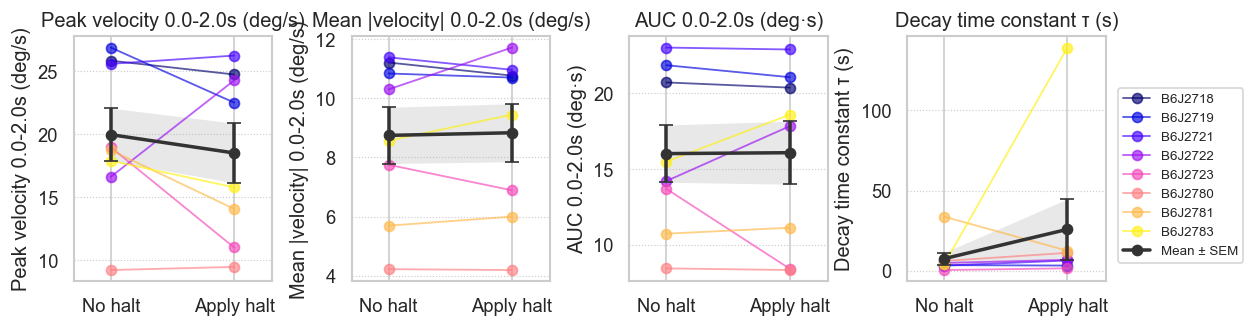

#### Turning metrics paired t-tests

,n_pairs,mean_difference,t_statistic,p_value,metric,metric_label,group_a,group_b
0,8,-1.455237,-0.883251,0.406410,peak_velocity_abs_1s,Peak velocity 0.0-2.0s (deg/s),No halt,Apply halt
1,8,0.089042,0.335209,0.747289,mean_abs_velocity_0_2s,Mean |velocity| 0.0-2.0s (deg/s),No halt,Apply halt
2,8,0.058922,0.061497,0.952683,auc_abs,AUC 0.0-2.0s (deg·s),No halt,Apply halt
3,7,17.851759,0.899763,0.402912,decay_tau,Decay time constant τ (s),No halt,Apply halt


✅ Saved: turning_metrics_ttests.csv


In [63]:
# Turning metric comparisons in a single figure (Apply halt vs No halt)
# ----------------------------------------------------------------------

# Build metric labels with actual window durations from configuration
analysis_window_duration = ANALYSIS_WINDOW_MEAN_PEAK[1] - ANALYSIS_WINDOW_MEAN_PEAK[0]
extended_window_duration = EXTENDED_RESPONSE_WINDOW[1] - EXTENDED_RESPONSE_WINDOW[0]

metric_specs = [
    ("peak_velocity_abs_1s", f"Peak velocity {ANALYSIS_WINDOW_MEAN_PEAK[0]}-{ANALYSIS_WINDOW_MEAN_PEAK[1]}s (deg/s)"),
    ("mean_abs_velocity_0_2s", f"Mean |velocity| {EXTENDED_RESPONSE_WINDOW[0]}-{EXTENDED_RESPONSE_WINDOW[1]}s (deg/s)"),
    ("auc_abs", f"AUC {ANALYSIS_WINDOW_MEAN_PEAK[0]}-{ANALYSIS_WINDOW_MEAN_PEAK[1]}s (deg·s)"),
    ("decay_tau", "Decay time constant τ (s)"),
]
plot_groups = ["No halt", "Apply halt"]
turning_stats_df = pd.DataFrame()

# Aggregate timing metrics directly from results_df
if results_df.empty:
    combined = pd.DataFrame()
else:
    metric_columns = [metric for metric, _ in metric_specs if metric in results_df.columns]
    if metric_columns:
        combined = (
            results_df.groupby(["mouse", "group"], dropna=False)[metric_columns]
            .mean()
            .reset_index()
        )
    else:
        combined = pd.DataFrame()
    
    # Merge in mean absolute velocity 0-2s
    if not mean_abs_velocity_by_mouse.empty and not combined.empty:
        combined = pd.merge(
            combined,
            mean_abs_velocity_by_mouse,
            on=["mouse", "group"],
            how="outer",
        )
    elif not mean_abs_velocity_by_mouse.empty:
        combined = mean_abs_velocity_by_mouse.copy()

if combined.empty:
    print("⚠️ No turning metrics available for comparison")
else:
    available_specs = [(metric, label) for metric, label in metric_specs if metric in combined.columns]
    if not available_specs:
        print("⚠️ Metrics not found in aggregated data")
    else:
        subplot_width_cm = 6.5
        subplot_height_cm = 7
        fig_width = len(available_specs) * subplot_width_cm / 2.54
        fig_height = subplot_height_cm / 2.54
        fig, axes = plt.subplots(1, len(available_specs), figsize=(fig_width, fig_height), sharey=False)
        if len(available_specs) == 1:
            axes = [axes]

        mouse_colors = assign_mouse_colors_consistent(combined["mouse"].dropna().unique())
        mean_handles = []
        mouse_handles: Dict[str, object] = {}
        turning_stats_records: List[Dict[str, object]] = []

        for ax, (metric, label) in zip(axes, available_specs):
            pivot = combined.pivot(index="mouse", columns="group", values=metric)
            groups_present = [group for group in plot_groups if group in pivot.columns]
            if len(groups_present) < 2:
                ax.text(0.5, 0.5, "Insufficient data", ha="center", va="center")
                ax.axis("off")
                continue

            group_a, group_b = groups_present[0], groups_present[1]
            stats_result = compute_paired_t_test(pivot, group_a, group_b)
            stats_result.update(
                {
                    "metric": metric,
                    "metric_label": label,
                    "group_a": group_a,
                    "group_b": group_b,
                }
            )
            turning_stats_records.append(stats_result)

            x_positions = np.arange(len(groups_present))

            for mouse in pivot.index:
                values = pivot.loc[mouse, groups_present]
                if values.isna().all():
                    continue
                valid_mask = values.notna()
                if not valid_mask.any():
                    continue
                x_mouse = x_positions[valid_mask.to_numpy(dtype=bool)]
                y_mouse = values[valid_mask].to_numpy(dtype=float)
                color = mouse_colors.get(mouse, "#1f77b4")
                if x_mouse.size == 1:
                    line, = ax.plot(
                        x_mouse,
                        y_mouse,
                        marker="o",
                        linestyle="none",
                        markersize=5,
                        alpha=0.8,
                        color=color,
                        zorder=2,
                    )
                else:
                    line, = ax.plot(
                        x_mouse,
                        y_mouse,
                        marker="o",
                        linewidth=1.1,
                        alpha=0.65,
                        color=color,
                        zorder=2,
                    )
                mouse_handles.setdefault(mouse, line)

            group_means = pivot[groups_present].mean(axis=0)
            group_sems = pivot[groups_present].apply(lambda col: sem(col.dropna()), axis=0)
            mean_values = group_means.to_numpy(dtype=float)
            sem_values = group_sems.to_numpy(dtype=float)
            valid_mask = np.isfinite(mean_values) & np.isfinite(sem_values)
            if valid_mask.any():
                x_valid = x_positions[valid_mask]
                mean_valid = mean_values[valid_mask]
                sem_valid = sem_values[valid_mask]
                ax.fill_between(
                    x_valid,
                    mean_valid - sem_valid,
                    mean_valid + sem_valid,
                    color="#b3b3b3",
                    alpha=0.3,
                    zorder=1,
                    linewidth=0,
                )

            error_container = ax.errorbar(
                x_positions,
                mean_values,
                yerr=sem_values,
                fmt="o-",
                color="#333333",
                linewidth=2.1,
                capsize=4,
                label="Mean ± SEM",
                zorder=3,
            )
            mean_handles.append(error_container)

            ax.set_xticks(x_positions)
            ax.set_xticklabels(groups_present)
            ax.set_xlim(-0.3, len(groups_present) - 1 + 0.31)
            ax.set_title(label)
            ax.set_ylabel(label)
            ax.grid(True, which="both", axis="y", linestyle=":", linewidth=0.7)

        legend_handles = list(mouse_handles.values())
        legend_labels = list(mouse_handles.keys())
        if mean_handles:
            legend_handles.append(mean_handles[0].lines[0])
            legend_labels.append("Mean ± SEM")
        if legend_handles:
            fig.legend(
                legend_handles,
                legend_labels,
                loc="center left",
                bbox_to_anchor=(0.85, 0.5),
                borderaxespad=0.0,
                frameon=True,
                fontsize=8,
            )

        fig.subplots_adjust(left=0, right=0.84, bottom=0.18, top=0.92, wspace=0.4)
        if OUTPUT_DIR is not None:
            fig.savefig(OUTPUT_DIR / "turning_metric_comparisons.pdf", format="pdf", bbox_inches="tight")
            print(f"✅ Saved: turning_metric_comparisons.pdf")
        plt.show()
        plt.close(fig)

        if turning_stats_records:
            turning_stats_df = pd.DataFrame(turning_stats_records)
            display(Markdown("#### Turning metrics paired t-tests"))
            display(turning_stats_df)
            if OUTPUT_DIR is not None:
                turning_stats_df.to_csv(OUTPUT_DIR / "turning_metrics_ttests.csv", index=False)
                print(f"✅ Saved: turning_metrics_ttests.csv")

In [64]:
# Average motor velocity traces by condition and turn direction
# ----------------------------------------------------------------------

if trace_samples_df.empty:
    per_mouse_traces = pd.DataFrame()
    avg_traces = pd.DataFrame()
else:
    per_mouse_traces = (
        trace_samples_df
        .groupby(["group", "direction", "mouse", "time"], dropna=False)["velocity"]
        .mean()
        .reset_index()
    )
    avg_traces = (
        per_mouse_traces
        .groupby(["group", "direction", "time"], dropna=False)
        .agg(
            mean_velocity=("velocity", "mean"),
            sem_velocity=("velocity", lambda x: sem(x) if len(x.dropna()) > 1 else 0.0),
            n_mice=("mouse", "nunique"),
        )
        .reset_index()
    )

avg_traces

,group,direction,time,mean_velocity,sem_velocity,n_mice
0,Apply halt,left,-6.000,-2.157877,1.217577,7
1,Apply halt,left,-5.999,-2.157458,1.218412,7
2,Apply halt,left,-5.998,-2.157044,1.219246,7
3,Apply halt,left,-5.997,-2.156629,1.220074,7
4,Apply halt,left,-5.996,-2.156222,1.220910,7
...,...,...,...,...,...,...
63999,No halt,right,9.996,0.472363,0.822687,8
64000,No halt,right,9.997,0.474304,0.822452,8
64001,No halt,right,9.998,0.476253,0.822226,8
64002,No halt,right,9.999,0.478190,0.821995,8


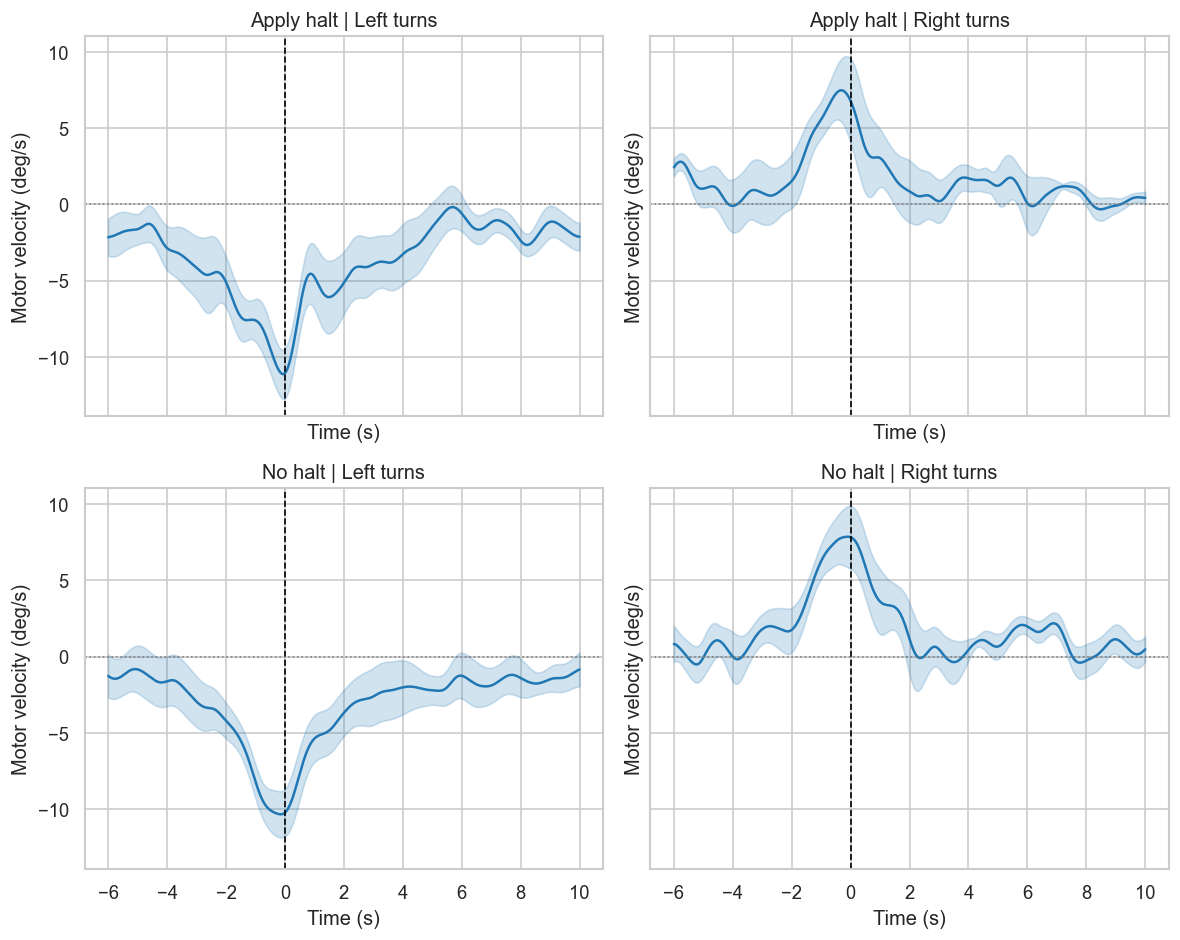

In [65]:
# 2x2 average motor velocity figure (Apply halt / No halt x Left / Right)
# ----------------------------------------------------------------------

if avg_traces.empty:
    print("⚠️ No averaged traces available for plotting")
else:
    plot_order = [
        ("Apply halt", "left"),
        ("Apply halt", "right"),
        ("No halt", "left"),
        ("No halt", "right"),
    ]
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    axes = axes.flatten()

    for ax, (group_name, direction) in zip(axes, plot_order):
        subset = avg_traces[
            (avg_traces["group"] == group_name)
            & (avg_traces["direction"] == direction)
        ]
        if subset.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.axis("off")
            continue

        ax.plot(subset["time"], subset["mean_velocity"], color="#1f77b4", linewidth=1.5)
        if "sem_velocity" in subset.columns:
            upper = subset["mean_velocity"] + subset["sem_velocity"].fillna(0)
            lower = subset["mean_velocity"] - subset["sem_velocity"].fillna(0)
            ax.fill_between(subset["time"], lower, upper, color="#1f77b4", alpha=0.2)

        ax.axvline(0, color="black", linestyle="--", linewidth=1)
        ax.axhline(0, color="grey", linestyle=":", linewidth=1)
        ax.set_title(f"{group_name} | {direction.capitalize()} turns")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Motor velocity (deg/s)")

    plt.tight_layout()
    plt.show()

### Alternative temporal dynamics analysis (better than decay fitting)

The exponential decay fit often fails because motor velocity shows complex, 
non-exponential dynamics. Better approaches:
1. **Windowed AUC**: Quantify response in different time phases
2. **Sustained response ratio**: Compare early vs late response magnitude  
3. **Time to baseline**: When does response return to pre-turn levels

In [66]:
# Compute alternative temporal metrics for each mouse
# ----------------------------------------------------------------------

if not trace_samples_df.empty:
    print("Computing alternative temporal dynamics metrics...")
    
    # Define time windows for AUC analysis
    AUC_WINDOWS = [
        (0.0, 0.5),   # Early response
        (0.5, 1.0),   # Mid response  
        (1.0, 2.0),   # Late response
        (0.0, 2.0),   # Total response
    ]
    
    alternative_metrics_records = []
    
    for (group, mouse, direction), group_df in trace_samples_df.groupby(["group", "mouse", "direction"]):
        # Compute windowed AUC
        auc_metrics = compute_windowed_auc(group_df, AUC_WINDOWS)
        
        # Compute sustained response ratio
        sustained_ratio = compute_sustained_response_ratio(group_df)
        
        # Compute time to baseline
        time_to_baseline = compute_time_to_baseline(group_df)
        
        # Compile all metrics
        alternative_metrics_records.append({
            "group": group,
            "mouse": mouse,
            "direction": direction,
            **auc_metrics,
            "sustained_ratio": sustained_ratio,
            "time_to_baseline": time_to_baseline,
        })
    
    alternative_metrics_df = pd.DataFrame(alternative_metrics_records)
    
    # Average across turn directions per mouse
    alt_metrics_by_mouse = (
        alternative_metrics_df.groupby(["group", "mouse"], dropna=False)
        .mean(numeric_only=True)
        .reset_index()
    )
    
    print(f"✅ Computed alternative metrics for {len(alt_metrics_by_mouse)} mouse-group combinations")
    display(Markdown("#### Alternative temporal dynamics metrics (per mouse)"))
    display(alt_metrics_by_mouse)
    
    if OUTPUT_DIR is not None:
        alt_metrics_by_mouse.to_csv(OUTPUT_DIR / "alternative_temporal_metrics.csv", index=False)
else:
    alternative_metrics_df = pd.DataFrame()
    alt_metrics_by_mouse = pd.DataFrame()
    print("⚠️ No trace data available for alternative metrics")

Computing alternative temporal dynamics metrics...
✅ Computed alternative metrics for 16 mouse-group combinations


#### Alternative temporal dynamics metrics (per mouse)

,group,mouse,auc_0.0_0.5s,auc_0.5_1.0s,auc_1.0_2.0s,auc_0.0_2.0s,sustained_ratio,time_to_baseline
0,Apply halt,B6J2718,6.609922,5.022106,8.750673,20.382700,0.438709,0.0160
1,Apply halt,B6J2719,5.734254,5.006835,10.331577,21.072667,0.690446,0.0060
2,Apply halt,B6J2721,6.744294,6.215888,9.941674,22.901856,0.412290,0.0005
3,Apply halt,B6J2722,5.477417,4.584543,7.774453,17.836413,0.509523,0.0000
4,Apply halt,B6J2723,2.399857,1.788813,4.229386,8.418056,0.804881,0.0055
5,Apply halt,B6J2780,2.297323,2.376476,3.656147,8.329947,0.785721,0.0000
6,Apply halt,B6J2781,3.788940,2.790441,4.547001,11.126381,0.266264,0.0000
7,Apply halt,B6J2783,4.787300,4.538041,9.267087,18.592428,0.976101,1.7905
8,No halt,B6J2718,6.556934,5.053384,9.115284,20.725603,0.278818,0.0000
9,No halt,B6J2719,6.958412,6.204073,8.700149,21.862634,0.437521,0.0000


In [67]:
# Statistical comparison of alternative metrics: Apply halt vs No halt
# ----------------------------------------------------------------------

if not alt_metrics_by_mouse.empty:
    print("\n" + "="*60)
    print("STATISTICAL COMPARISON: Apply halt vs No halt")
    print("="*60)
    
    # Define metrics to compare
    alt_metrics_to_compare = [
        ("auc_0.0_0.5s", "Early AUC 0-0.5s (deg)"),
        ("auc_0.5_1.0s", "Mid AUC 0.5-1s (deg)"),
        ("auc_1.0_2.0s", "Late AUC 1-2s (deg)"),
        ("auc_0.0_2.0s", "Total AUC 0-2s (deg)"),
        ("sustained_ratio", "Sustained response ratio (late/early)"),
        ("time_to_baseline", "Time to baseline (s)"),
    ]
    
    alt_stats_records = []
    
    for metric, label in alt_metrics_to_compare:
        if metric not in alt_metrics_by_mouse.columns:
            continue
        
        # Create pivot table
        pivot = alt_metrics_by_mouse.pivot(index="mouse", columns="group", values=metric)
        
        if "No halt" in pivot.columns and "Apply halt" in pivot.columns:
            stats_result = compute_paired_t_test(pivot, "No halt", "Apply halt")
            
            # Add descriptive statistics
            no_halt_vals = pivot["No halt"].dropna()
            apply_halt_vals = pivot["Apply halt"].dropna()
            
            stats_result.update({
                "metric": metric,
                "metric_label": label,
                "no_halt_mean": float(no_halt_vals.mean()) if len(no_halt_vals) > 0 else float("nan"),
                "no_halt_sem": float(sem(no_halt_vals)) if len(no_halt_vals) > 1 else float("nan"),
                "apply_halt_mean": float(apply_halt_vals.mean()) if len(apply_halt_vals) > 0 else float("nan"),
                "apply_halt_sem": float(sem(apply_halt_vals)) if len(apply_halt_vals) > 1 else float("nan"),
            })
            
            alt_stats_records.append(stats_result)
    
    if alt_stats_records:
        alt_stats_df = pd.DataFrame(alt_stats_records)
        
        # Reorder columns for clarity
        col_order = [
            "metric_label", 
            "no_halt_mean", "no_halt_sem",
            "apply_halt_mean", "apply_halt_sem",
            "mean_difference", "t_statistic", "p_value", "n_pairs"
        ]
        alt_stats_df = alt_stats_df[[col for col in col_order if col in alt_stats_df.columns]]
        
        display(Markdown("#### Paired t-tests for alternative temporal metrics"))
        display(alt_stats_df)
        
        if OUTPUT_DIR is not None:
            alt_stats_df.to_csv(OUTPUT_DIR / "alternative_metrics_ttests.csv", index=False)
        
        # Highlight significant results
        if "p_value" in alt_stats_df.columns:
            sig_results = alt_stats_df[alt_stats_df["p_value"] < 0.05]
            if not sig_results.empty:
                display(Markdown("#### Significant differences (p < 0.05)"))
                display(sig_results)
    else:
        alt_stats_df = pd.DataFrame()
        print("⚠️ Could not perform statistical comparisons")
else:
    alt_stats_df = pd.DataFrame()


STATISTICAL COMPARISON: Apply halt vs No halt


#### Paired t-tests for alternative temporal metrics

,metric_label,no_halt_mean,no_halt_sem,apply_halt_mean,apply_halt_sem,mean_difference,t_statistic,p_value,n_pairs
0,Early AUC 0-0.5s (deg),4.845045,0.630703,4.729913,0.618105,-0.115132,-0.418932,0.687821,8
1,Mid AUC 0.5-1s (deg),4.009958,0.550871,4.040393,0.544041,0.030435,0.098254,0.924485,8
2,Late AUC 1-2s (deg),7.168631,0.765993,7.312250,0.969647,0.143619,0.244915,0.813547,8
3,Total AUC 0-2s (deg),16.023634,1.888932,16.082556,2.081732,0.058922,0.061497,0.952683,8
4,Sustained response ratio (late/early),3.331635,1.321999,0.610492,0.085151,-2.721143,-2.045364,0.080076,8
5,Time to baseline (s),0.008375,0.007680,0.227313,0.223321,0.218938,0.974500,0.362273,8


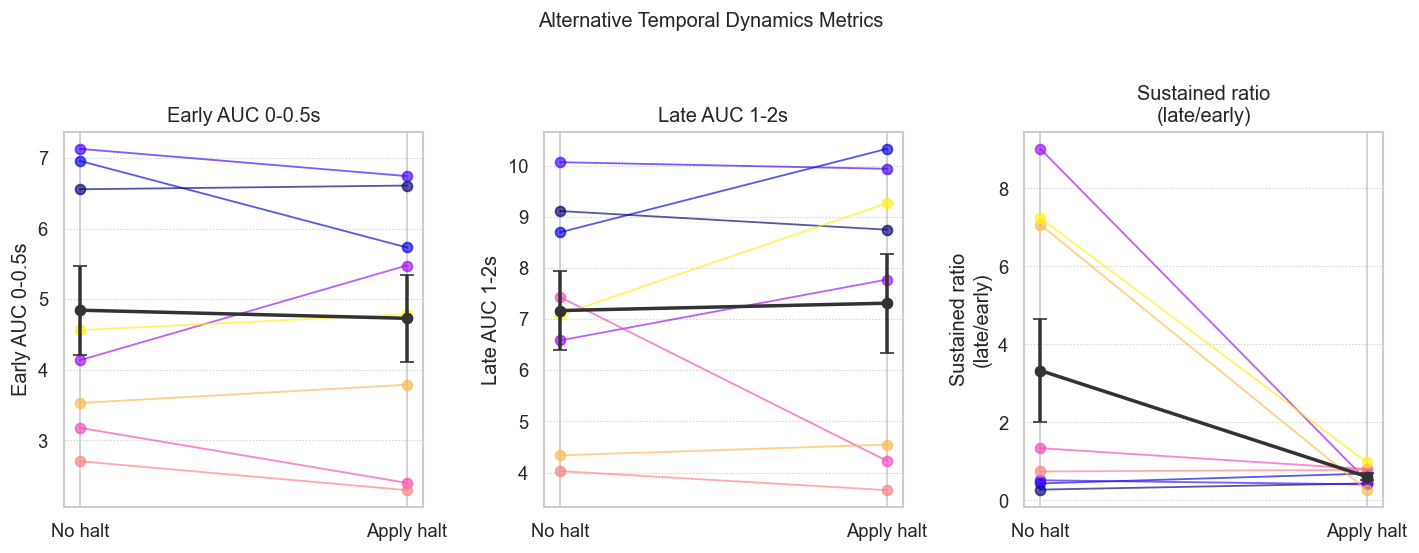

In [68]:
# Visualization: Alternative metrics comparison
# ----------------------------------------------------------------------

if not alt_metrics_by_mouse.empty:
    # Select key metrics to visualize
    viz_metrics = [
        ("auc_0.0_0.5s", "Early AUC 0-0.5s"),
        ("auc_1.0_2.0s", "Late AUC 1-2s"),  
        ("sustained_ratio", "Sustained ratio\n(late/early)"),
    ]
    
    # Filter to metrics that exist
    viz_metrics = [(m, l) for m, l in viz_metrics if m in alt_metrics_by_mouse.columns]
    
    if viz_metrics:
        fig, axes = plt.subplots(1, len(viz_metrics), figsize=(4*len(viz_metrics), 4.5))
        if len(viz_metrics) == 1:
            axes = [axes]
        
        mouse_colors = assign_mouse_colors_consistent(alt_metrics_by_mouse["mouse"].unique())
        
        for ax, (metric, label) in zip(axes, viz_metrics):
            pivot = alt_metrics_by_mouse.pivot(index="mouse", columns="group", values=metric)
            groups_present = [g for g in ["No halt", "Apply halt"] if g in pivot.columns]
            
            if len(groups_present) < 2:
                ax.text(0.5, 0.5, "Insufficient data", ha="center", va="center")
                ax.axis("off")
                continue
            
            x_positions = np.arange(len(groups_present))
            
            # Plot individual mice
            for mouse in pivot.index:
                values = pivot.loc[mouse, groups_present]
                if values.isna().all():
                    continue
                ax.plot(
                    x_positions,
                    values.to_numpy(dtype=float),
                    marker="o",
                    linewidth=1.1,
                    alpha=0.65,
                    color=mouse_colors.get(mouse, "#1f77b4"),
                    zorder=2,
                )
            
            # Plot group means
            group_means = pivot[groups_present].mean(axis=0)
            group_sems = pivot[groups_present].apply(lambda col: sem(col.dropna()), axis=0)
            
            ax.errorbar(
                x_positions,
                group_means.to_numpy(dtype=float),
                yerr=group_sems.to_numpy(dtype=float),
                fmt="o-",
                color="#333333",
                linewidth=2.1,
                capsize=4,
                label="Mean ± SEM",
                zorder=3,
            )
            
            ax.set_xticks(x_positions)
            ax.set_xticklabels(groups_present)
            ax.set_ylabel(label)
            ax.set_title(label)
            ax.grid(True, which="both", axis="y", linestyle=":", linewidth=0.7)
        
        plt.suptitle("Alternative Temporal Dynamics Metrics", fontsize=12, y=1.02)
        plt.tight_layout()
        
        if OUTPUT_DIR is not None:
            fig.savefig(OUTPUT_DIR / "alternative_metrics_comparison.pdf", format="pdf", bbox_inches="tight")
        
        plt.show()
        plt.close(fig)

### Single Mouse Plots - Eye Tracking, Turning, and Running
Plot individual mouse data (comparing Apply halt vs No halt conditions)

In [ ]:
# Single Mouse Eye Tracking Plot
# ----------------------------------------------------------------------
# NOTE: This uses the already-loaded trace data (eye_traces dictionary)
# which contains the same data as the saved CSV files, just in memory.
# Mean and SEM are calculated across trials for the specified mouse.

# Configure which mouse to plot
SINGLE_MOUSE_ID = "B6J2721"  # Change this to plot a different mouse

if not eye_traces:
    print(f"⚠️ No eye tracking traces available for plotting")
else:
    print(f"\n📊 Creating single-mouse eye tracking plot for: {SINGLE_MOUSE_ID}")
    
    # Check if mouse exists in the data
    available_mice = set()
    for metric_name, df in eye_traces.items():
        if not df.empty and "mouse" in df.columns:
            available_mice.update(df["mouse"].unique())
    
    if SINGLE_MOUSE_ID not in available_mice:
        print(f"⚠️ Mouse {SINGLE_MOUSE_ID} not found in eye tracking data")
        print(f"   Available mice: {sorted(available_mice)}")
    else:
        # Create 4-panel figure (saccade, pupil, eye_pos_left, eye_pos_right)
        fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=False)
        
        plot_idx = 0
        
        # Plot Saccade and Pupil (averaged across turns for this mouse)
        for metric_name in ["saccade", "pupil"]:
            ax = axes[plot_idx]
            metric_traces = eye_traces.get(metric_name, pd.DataFrame())
            
            if metric_traces.empty:
                ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
                ax.set_title(f"{plot_labels[metric_name]} | {SINGLE_MOUSE_ID}")
                ax.axis("off")
                plot_idx += 1
                continue
            
            # Filter for this mouse
            mouse_data = metric_traces[metric_traces["mouse"] == SINGLE_MOUSE_ID]
            
            if mouse_data.empty:
                ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
                ax.set_title(f"{plot_labels[metric_name]} | {SINGLE_MOUSE_ID}")
                ax.axis("off")
                plot_idx += 1
                continue
            
            # Diagnostic: show how many unique trials/files per group
            if metric_name == "saccade" and plot_idx == 0:  # Print once
                for grp in mouse_data["group"].unique():
                    grp_data = mouse_data[mouse_data["group"] == grp]
                    # Count unique csv files if available
                    if "csv_path" in grp_data.columns:
                        n_trials = grp_data["csv_path"].nunique()
                    else:
                        # Estimate from number of rows at a single time point
                        sample_time = grp_data["time"].iloc[0] if not grp_data.empty else None
                        if sample_time is not None:
                            n_trials = len(grp_data[grp_data["time"] == sample_time])
                        else:
                            n_trials = "unknown"
                    print(f"   {metric_name} | {grp}: {n_trials} trials for {SINGLE_MOUSE_ID}")
            
            # Average across trials for each group with SEM
            # This averages all trials (different turning events) for this mouse
            mouse_avg = (
                mouse_data.groupby(["group", "time"], dropna=False)
                .agg(
                    mean_value=("value", "mean"),
                    sem_value=("value", lambda x: sem(x) if len(x.dropna()) > 1 else 0.0),
                    n_trials=("value", "count"),
                )
                .reset_index()
            )
            
            # Plot for each group
            for group_name in ["Apply halt", "No halt"]:
                subset = mouse_avg[mouse_avg["group"] == group_name]
                if subset.empty:
                    continue
                
                color = plot_colors[metric_name]
                alpha = 1.0 if group_name == "Apply halt" else 0.6
                linestyle = "-" if group_name == "Apply halt" else "--"
                
                ax.plot(subset["time"], subset["mean_value"], 
                       color=color, linewidth=1.5, alpha=alpha, linestyle=linestyle,
                       label=group_name)
                
                # Add SEM shading
                if "sem_value" in subset.columns:
                    upper = subset["mean_value"] + subset["sem_value"].fillna(0)
                    lower = subset["mean_value"] - subset["sem_value"].fillna(0)
                    ax.fill_between(subset["time"], lower, upper, 
                                   color=color, alpha=0.15)
            
            ax.axvline(0, color="black", linestyle="--", linewidth=1)
            ax.axhline(0, color="grey", linestyle=":", linewidth=0.8)
            ax.set_title(f"{plot_labels[metric_name]}", fontsize=11)
            ax.set_xlabel("Time (s)")
            ax.set_ylabel(plot_labels[metric_name])
            ax.legend(fontsize=9, loc='best')
            ax.grid(True, alpha=0.3)
            plot_idx += 1
        
        # Plot Eye Position (separate for left and right turns)
        eye_pos_traces = eye_traces.get("eye_position", pd.DataFrame())
        
        for turn_direction in ["left", "right"]:
            ax = axes[plot_idx]
            
            if eye_pos_traces.empty:
                ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
                ax.set_title(f"Eye Position | {turn_direction.capitalize()}")
                ax.axis("off")
                plot_idx += 1
                continue
            
            # Filter for this mouse and direction
            mouse_direction_data = eye_pos_traces[
                (eye_pos_traces["mouse"] == SINGLE_MOUSE_ID) & 
                (eye_pos_traces["direction"] == turn_direction)
            ]
            
            if mouse_direction_data.empty:
                ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
                ax.set_title(f"Eye Position | {turn_direction.capitalize()}")
                ax.axis("off")
                plot_idx += 1
                continue
            
            # Average across trials for each group with SEM
            mouse_avg = (
                mouse_direction_data.groupby(["group", "time"], dropna=False)
                .agg(
                    mean_value=("value", "mean"),
                    sem_value=("value", lambda x: sem(x) if len(x.dropna()) > 1 else 0.0),
                )
                .reset_index()
            )
            
            # Plot for each group
            for group_name in ["Apply halt", "No halt"]:
                subset = mouse_avg[mouse_avg["group"] == group_name]
                if subset.empty:
                    continue
                
                color = plot_colors[f"eye_position_{turn_direction}"]
                alpha = 1.0 if group_name == "Apply halt" else 0.6
                linestyle = "-" if group_name == "Apply halt" else "--"
                
                ax.plot(subset["time"], subset["mean_value"], 
                       color=color, linewidth=1.5, alpha=alpha, linestyle=linestyle,
                       label=group_name)
                
                # Add SEM shading
                if "sem_value" in subset.columns:
                    upper = subset["mean_value"] + subset["sem_value"].fillna(0)
                    lower = subset["mean_value"] - subset["sem_value"].fillna(0)
                    ax.fill_between(subset["time"], lower, upper, 
                                   color=color, alpha=0.15)
            
            ax.axvline(0, color="black", linestyle="--", linewidth=1)
            ax.axhline(0, color="grey", linestyle=":", linewidth=0.8)
            ax.set_title(f"Eye Position (X) | {turn_direction.capitalize()}", fontsize=11)
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Eye Position (X)")
            ax.legend(fontsize=9, loc='best')
            ax.grid(True, alpha=0.3)
            plot_idx += 1
        
        plt.suptitle(f"Eye Tracking - Mouse {SINGLE_MOUSE_ID}", fontsize=13, y=1.02)
        plt.tight_layout()
        
        if OUTPUT_DIR is not None:
            output_path = OUTPUT_DIR / f"eye_tracking_{SINGLE_MOUSE_ID}.pdf"
            fig.savefig(output_path, format="pdf", bbox_inches="tight")
            print(f"✅ Saved: {output_path}")
        
        plt.show()
        plt.close(fig)


📊 Creating single-mouse eye tracking plot for: B6J2721
   saccade | Apply halt: 29 trials for B6J2721
   saccade | No halt: 45 trials for B6J2721



📊 Creating single-mouse turning velocity plot for: B6J2719
✅ Saved: /Volumes/RanczLab2/DATA_NEW/turning_analysis__Cohort1_rotation_Visual_mismatch_day3__Cohort3_rotation_Visual_mismatch_day3/turning_velocity_B6J2719.pdf


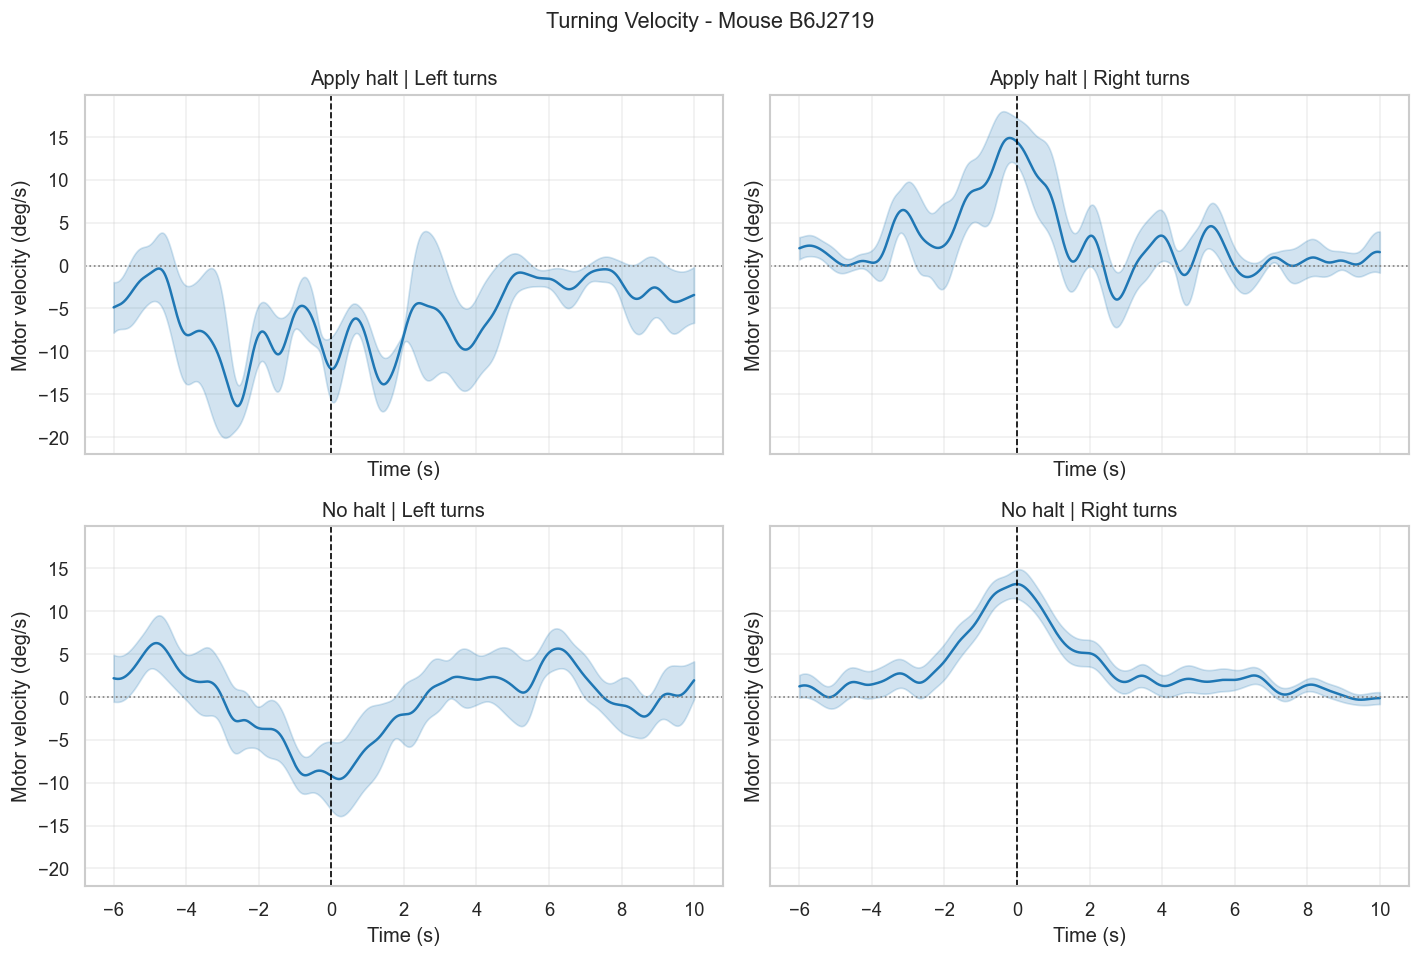

In [74]:
# Single Mouse Turning Velocity Plot
# ----------------------------------------------------------------------

if trace_samples_df.empty:
    print(f"⚠️ No turning traces available for plotting")
else:
    print(f"\n📊 Creating single-mouse turning velocity plot for: {SINGLE_MOUSE_ID}")
    
    # Check if mouse exists
    if SINGLE_MOUSE_ID not in trace_samples_df["mouse"].unique():
        print(f"⚠️ Mouse {SINGLE_MOUSE_ID} not found in turning data")
        print(f"   Available mice: {sorted(trace_samples_df['mouse'].unique())}")
    else:
        # Filter for this mouse
        mouse_data = trace_samples_df[trace_samples_df["mouse"] == SINGLE_MOUSE_ID]
        
        # Average across trials for each group and direction with SEM
        mouse_avg = (
            mouse_data.groupby(["group", "direction", "time"], dropna=False)
            .agg(
                mean_velocity=("velocity", "mean"),
                sem_velocity=("velocity", lambda x: sem(x) if len(x.dropna()) > 1 else 0.0),
            )
            .reset_index()
        )
        
        # Create 2x2 plot (left/right x halt/no-halt)
        fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
        
        plot_order = [
            ("Apply halt", "left"),
            ("Apply halt", "right"),
            ("No halt", "left"),
            ("No halt", "right"),
        ]
        
        axes_flat = axes.flatten()
        
        for ax, (group_name, direction) in zip(axes_flat, plot_order):
            subset = mouse_avg[
                (mouse_avg["group"] == group_name) & 
                (mouse_avg["direction"] == direction)
            ]
            
            if subset.empty:
                ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
                ax.set_title(f"{group_name} | {direction.capitalize()} turns")
                ax.axis("off")
                continue
            
            # Plot mean line
            ax.plot(subset["time"], subset["mean_velocity"], color="#1f77b4", linewidth=1.5)
            
            # Add SEM shading
            if "sem_velocity" in subset.columns:
                upper = subset["mean_velocity"] + subset["sem_velocity"].fillna(0)
                lower = subset["mean_velocity"] - subset["sem_velocity"].fillna(0)
                ax.fill_between(subset["time"], lower, upper, color="#1f77b4", alpha=0.2)
            
            ax.axvline(0, color="black", linestyle="--", linewidth=1)
            ax.axhline(0, color="grey", linestyle=":", linewidth=1)
            ax.set_title(f"{group_name} | {direction.capitalize()} turns")
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Motor velocity (deg/s)")
            ax.grid(True, alpha=0.3)
        
        plt.suptitle(f"Turning Velocity - Mouse {SINGLE_MOUSE_ID}", fontsize=13, y=0.995)
        plt.tight_layout()
        
        if OUTPUT_DIR is not None:
            output_path = OUTPUT_DIR / f"turning_velocity_{SINGLE_MOUSE_ID}.pdf"
            fig.savefig(output_path, format="pdf", bbox_inches="tight")
            print(f"✅ Saved: {output_path}")
        
        plt.show()
        plt.close(fig)


📊 Creating single-mouse running velocity plot for: B6J2719
✅ Saved: /Volumes/RanczLab2/DATA_NEW/turning_analysis__Cohort1_rotation_Visual_mismatch_day3__Cohort3_rotation_Visual_mismatch_day3/running_velocity_B6J2719.pdf


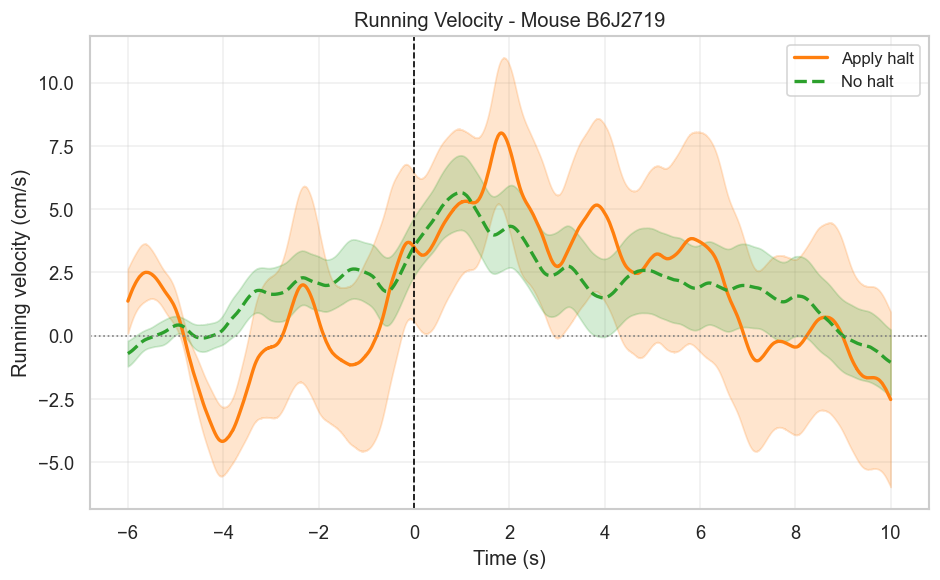

In [75]:
# Single Mouse Running Velocity Plot  
# ----------------------------------------------------------------------

if running_trace_samples_df.empty:
    print(f"⚠️ No running traces available for plotting")
else:
    print(f"\n📊 Creating single-mouse running velocity plot for: {SINGLE_MOUSE_ID}")
    
    # Check if mouse exists
    if SINGLE_MOUSE_ID not in running_trace_samples_df["mouse"].unique():
        print(f"⚠️ Mouse {SINGLE_MOUSE_ID} not found in running data")
        print(f"   Available mice: {sorted(running_trace_samples_df['mouse'].unique())}")
    else:
        # Filter for this mouse
        mouse_data = running_trace_samples_df[running_trace_samples_df["mouse"] == SINGLE_MOUSE_ID]
        
        # Average across all trials for each group with SEM (combining left and right turns)
        mouse_avg = (
            mouse_data.groupby(["group", "time"], dropna=False)
            .agg(
                mean_velocity=("velocity", "mean"),
                sem_velocity=("velocity", lambda x: sem(x) if len(x.dropna()) > 1 else 0.0),
            )
            .reset_index()
        )
        
        # Create single plot comparing halt vs no-halt
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        
        for group_name in ["Apply halt", "No halt"]:
            subset = mouse_avg[mouse_avg["group"] == group_name]
            
            if subset.empty:
                continue
            
            color = "#ff7f0e" if group_name == "Apply halt" else "#2ca02c"
            linestyle = "-" if group_name == "Apply halt" else "--"
            
            # Plot mean line
            ax.plot(subset["time"], subset["mean_velocity"], 
                   color=color, linewidth=2, linestyle=linestyle, label=group_name)
            
            # Add SEM shading
            if "sem_velocity" in subset.columns:
                upper = subset["mean_velocity"] + subset["sem_velocity"].fillna(0)
                lower = subset["mean_velocity"] - subset["sem_velocity"].fillna(0)
                ax.fill_between(subset["time"], lower, upper, color=color, alpha=0.2)
        
        ax.axvline(0, color="black", linestyle="--", linewidth=1)
        ax.axhline(0, color="grey", linestyle=":", linewidth=1)
        ax.set_title(f"Running Velocity - Mouse {SINGLE_MOUSE_ID}", fontsize=12)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Running velocity (cm/s)")
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if OUTPUT_DIR is not None:
            output_path = OUTPUT_DIR / f"running_velocity_{SINGLE_MOUSE_ID}.pdf"
            fig.savefig(output_path, format="pdf", bbox_inches="tight")
            print(f"✅ Saved: {output_path}")
        
        plt.show()
        plt.close(fig)

In [76]:
# Summary: Single mouse plots saved
# ----------------------------------------------------------------------
if OUTPUT_DIR is not None:
    print(f"\n✅ Single-mouse plots for {SINGLE_MOUSE_ID} saved to:")
    print(f"   {OUTPUT_DIR / f'eye_tracking_{SINGLE_MOUSE_ID}.pdf'}")
    print(f"   {OUTPUT_DIR / f'turning_velocity_{SINGLE_MOUSE_ID}.pdf'}")
    print(f"   {OUTPUT_DIR / f'running_velocity_{SINGLE_MOUSE_ID}.pdf'}")
    print(f"\n💡 To plot a different mouse, change SINGLE_MOUSE_ID at the top of the eye tracking cell")


✅ Single-mouse plots for B6J2719 saved to:
   /Volumes/RanczLab2/DATA_NEW/turning_analysis__Cohort1_rotation_Visual_mismatch_day3__Cohort3_rotation_Visual_mismatch_day3/eye_tracking_B6J2719.pdf
   /Volumes/RanczLab2/DATA_NEW/turning_analysis__Cohort1_rotation_Visual_mismatch_day3__Cohort3_rotation_Visual_mismatch_day3/turning_velocity_B6J2719.pdf
   /Volumes/RanczLab2/DATA_NEW/turning_analysis__Cohort1_rotation_Visual_mismatch_day3__Cohort3_rotation_Visual_mismatch_day3/running_velocity_B6J2719.pdf

💡 To plot a different mouse, change SINGLE_MOUSE_ID at the top of the eye tracking cell
